## Problem Statement 

X Education sells online courses to industry professionals and attracts many potential leads daily through marketing on various websites and search engines. Leads are generated when visitors provide contact information or are referred by past customers. However, only about 30% of these leads convert into paying customers.

The company wants to improve its lead conversion rate by identifying the most promising leads, termed 'Hot Leads'. By focusing on these leads, they aim to increase the conversion rate to around 80%. To achieve this, you are tasked with building a model to assign a lead score to each lead, indicating their likelihood of conversion. This targeted approach should help the sales team prioritize and communicate more effectively with high-potential leads, ultimately improving overall conversion rates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Step 1 : Reading the Data

In [2]:
# Reading the Leads file
lead = pd.read_csv('Leads.csv')
pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.max_rows', None)     # Show all rows
lead.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [3]:
lead.shape

(9240, 37)

In [4]:
lead.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
lead.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
max                     20.000000

In [6]:
# Checking for missing values
round(lead.isnull().mean().sort_values(ascending=False) * 100,2)

Lead Quality                                     51.59
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Score                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Profile Index                       45.65
Tags                                             36.29
Lead Profile                                     29.32
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
How did you hear about X Education               23.89
Specialization                                   15.56
City                                             15.37
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Receive More Updates About Our Courses            0.00
I agree to

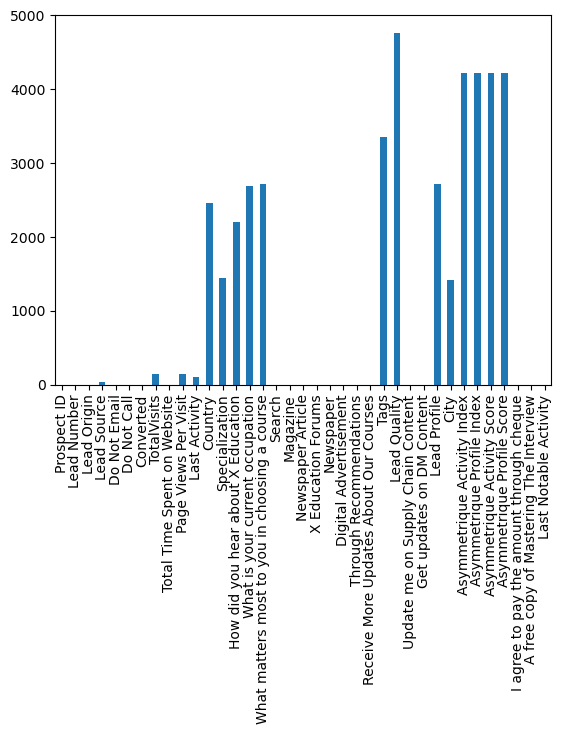

In [7]:
# Plotting bar plot for missing values
lead.isnull().sum().plot(kind='bar')
plt.show()

## Step 2: Data Cleaning and Preparation

### Data Preparation

- Converting Yes/No to 1/0


- Converting selects to NaNs

In [8]:
# checking for categorical variables with Select as values
lead.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Prospect ID                                    9240 non-null   object
 1   Lead Origin                                    9240 non-null   object
 2   Lead Source                                    9204 non-null   object
 3   Do Not Email                                   9240 non-null   object
 4   Do Not Call                                    9240 non-null   object
 5   Last Activity                                  9137 non-null   object
 6   Country                                        6779 non-null   object
 7   Specialization                                 7802 non-null   object
 8   How did you hear about X Education             7033 non-null   object
 9   What is your current occupation                6550 non-null   

In [9]:
for i in lead.iloc[:,1:].select_dtypes(include='object').columns:
    print(i)
    print('----------------------------------')
    print(lead[i].value_counts(normalize = True))
    print('----------------------------------')

Lead Origin
----------------------------------
Lead Origin
Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: proportion, dtype: float64
----------------------------------
Lead Source
----------------------------------
Lead Source
Google               0.311604
Direct Traffic       0.276293
Olark Chat           0.190678
Organic Search       0.125380
Reference            0.058018
Welingak Website     0.015428
Referral Sites       0.013581
Facebook             0.005976
bing                 0.000652
google               0.000543
Click2call           0.000435
Press_Release        0.000217
Social Media         0.000217
Live Chat            0.000217
youtubechannel       0.000109
testone              0.000109
Pay per Click Ads    0.000109
welearnblog_Home     0.000109
WeLearn              0.000109
blog                 0.000109
NC_EDM               0.000109
Name

In [10]:
# Converting columns having 'Select' to 'NaN'
lead = lead.replace('Select',np.nan)


In [11]:
lead.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [12]:
round(lead.isnull().mean()*100,2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

### Missing values Treatment

In [13]:
# Dropping columns having more than 70% null values
lead=lead.drop(lead.iloc[: ,list(round(lead.isnull().mean()*100,2)>70.0)].columns,axis = 1)

In [14]:
lead.isnull().mean()*100

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   36.580087
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.000000
Magazine                                          0.0000

In [15]:
# Dropping columns 'Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score' that are of no use 
cols = ['Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score']
lead=lead.drop(cols,axis = 1)
lead.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0     NaN                      NaN                      Unemployed   
1   India                      NaN                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India                      NaN                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    City  \
0                                No                        No     NaN   
1                                No                        No     NaN   
2                                No                        No  Mumbai   
3                                No                        No  Mumbai   
4                                No                        No  Mumbai   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   
2                

In [16]:
# As 'Lead Quality' completely depended on the decision of the employee it is safer to impute 'Not sure' for NaN
lead['Lead Quality']=lead['Lead Quality'].fillna('Not Sure')
# checking for missing values
lead['Lead Quality'].isnull().mean()*100

0.0

In [17]:
print(lead['Country'].value_counts())

Country
India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malays

In [18]:
# as most of the values are India we can impute "India"
lead['Country']=lead['Country'].fillna('India')

In [19]:
print(lead['Specialization'].value_counts())

Specialization
Finance Management                   976
Human Resource Management            848
Marketing Management                 838
Operations Management                503
Business Administration              403
IT Projects Management               366
Supply Chain Management              349
Banking, Investment And Insurance    338
Travel and Tourism                   203
Media and Advertising                203
International Business               178
Healthcare Management                159
Hospitality Management               114
E-COMMERCE                           112
Retail Management                    100
Rural and Agribusiness                73
E-Business                            57
Services Excellence                   40
Name: count, dtype: int64


In [20]:
# There is very minute difference present in top 3 variable so it is better to impute 'Other Specialization' for NaN
lead['Specialization']=lead['Specialization'].fillna('Other Specialization')

In [21]:
print(lead['Tags'].value_counts())

Tags
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to O

In [22]:
# Most of the values contain 'Will revert after reading the email' we can impute it
lead['Tags']=lead['Tags'].fillna('Will revert after reading the email')

In [23]:
print(lead['City'].value_counts())

City
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64


In [24]:
# Most of the values consist 'Mumbai' we can impute in for null values
lead['City']=lead['City'].fillna('Mumbai')

In [25]:
print(lead['What matters most to you in choosing a course'].value_counts())
#most of the values consist 'Better Career Prospects' it is better to impute it
lead['What matters most to you in choosing a course']=lead['What matters most to you in choosing a course'].fillna('Better Career Prospects')
lead['What matters most to you in choosing a course'].value_counts()


What matters most to you in choosing a course
Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64


What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [26]:
# most of the values consist 'Unemployed' so it is better to impute
print(lead['What is your current occupation'].value_counts())
lead['What is your current occupation']=lead['What is your current occupation'].fillna('Unemployed')


What is your current occupation
Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: count, dtype: int64


In [27]:
# Dropping columns that  having less than 2% Null values
lead.dropna(inplace=True)

In [28]:
# Checking for null Values
lead.isnull().mean()*100

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                            

## Step 3: Exploratory Data Analysis

In [29]:
# checking for duplicates 
lead[lead.duplicated()]

Empty DataFrame
Columns: [Prospect ID, Lead Number, Lead Origin, Lead Source, Do Not Email, Do Not Call, Converted, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Last Activity, Country, Specialization, What is your current occupation, What matters most to you in choosing a course, Search, Magazine, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement, Through Recommendations, Receive More Updates About Our Courses, Tags, Lead Quality, Update me on Supply Chain Content, Get updates on DM Content, City, I agree to pay the amount through cheque, A free copy of Mastering The Interview, Last Notable Activity]
Index: []

In [30]:
# checking for any imbalances with the target variable
lead['Converted'].value_counts(normalize=True)

Converted
0    0.621446
1    0.378554
Name: proportion, dtype: float64

-  We have a well-balanced representation of both data classes, so we can proceed with further analysis.








### Lead Origin

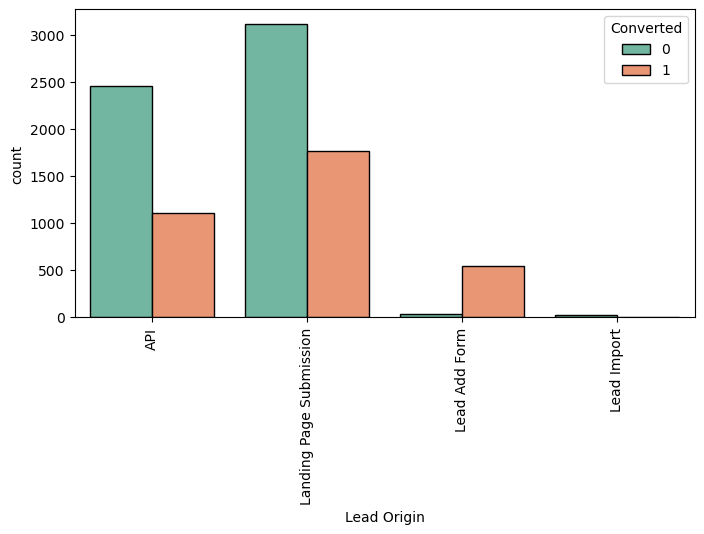

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(x='Lead Origin',hue= 'Converted',data= lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inferences
- API and Landing Page Submission has 30-35% conversion rate but with less count of lead origin.
- Lead Add Form has approxmately 90% of conversion rate but count is very low.
- Lead Import has low count and conversion rate.

### Lead Source 

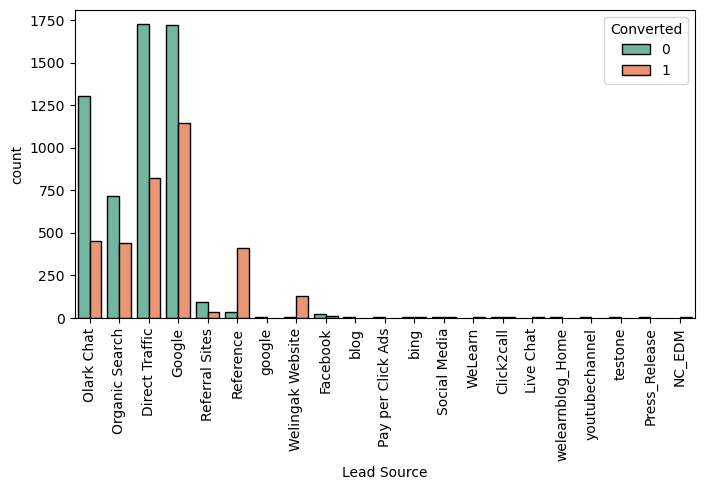

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(x='Lead Source',hue='Converted',data= lead,palette='Set2',edgecolor='black')
plt.xticks(rotation = 90)
plt.show()

In [33]:
# as we can see from the above countplot Google and google both are same so we are replacing google with Google
lead['Lead Source']=lead['Lead Source'].replace('google','Google')

In [34]:
lead['Lead Source'].value_counts()

Lead Source
Google               2873
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference             443
Welingak Website      129
Referral Sites        125
Facebook               31
bing                    6
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: count, dtype: int64

In [35]:
# creation a seperate category 'Others' and placing the values having less count 
lead['Lead Source']= lead['Lead Source'].replace(['bing','Click2call','Social Media','Live Chat',
                                                 'Press_Release','Pay per Click Ads','blog',
                                                 'WeLearn','welearnblog_Home','youtubechannel',
                                                 'testone','NC_EDM'],'Others')

In [36]:
lead['Lead Source'].value_counts()

Lead Source
Google              2873
Direct Traffic      2543
Olark Chat          1753
Organic Search      1154
Reference            443
Welingak Website     129
Referral Sites       125
Facebook              31
Others                23
Name: count, dtype: int64

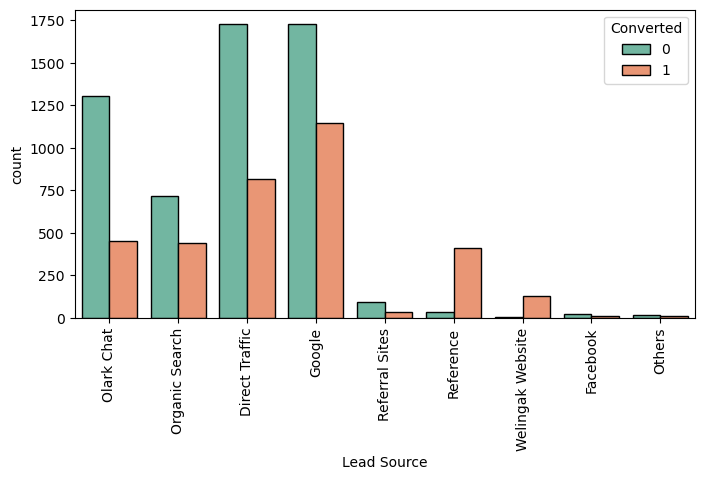

In [37]:
# Now againg plotting a coutplot
plt.figure(figsize=(8,4))
sns.countplot(x='Lead Source',hue='Converted',data= lead,palette='Set2',edgecolor='black')
plt.xticks(rotation = 90)
plt.show()

##### Inferences
- Google and Direct Traffic has the highest conversion rate
- Refernces and Welingak website has high conversion rate but low counts

### Do Not Email

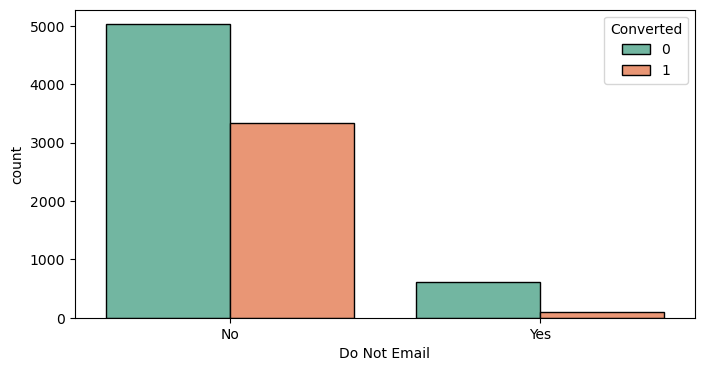

In [38]:
plt.figure(figsize=(8,4))
sns.countplot(x='Do Not Email',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.show()

##### Inferences
- most of them are 0 so we cannot make any inferences

### Do Not Call

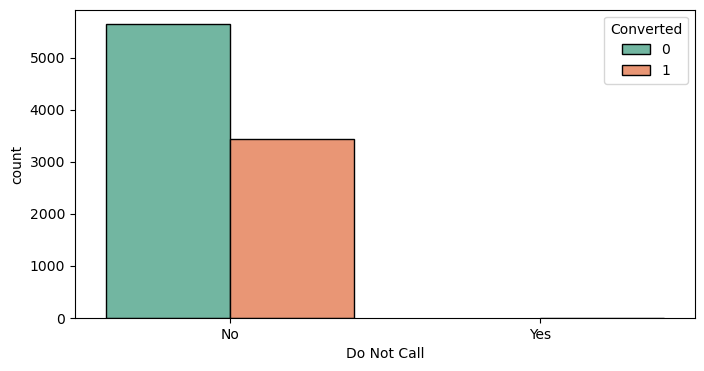

In [39]:
plt.figure(figsize=(8,4))
sns.countplot(x='Do Not Call',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.show()

##### Inferences
- most of them are 0 so we cannot make any inferences

### TotalVisits

In [40]:
lead.TotalVisits.describe(percentiles=[0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    9074.000000
mean        3.456028
std         4.858802
min         0.000000
5%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

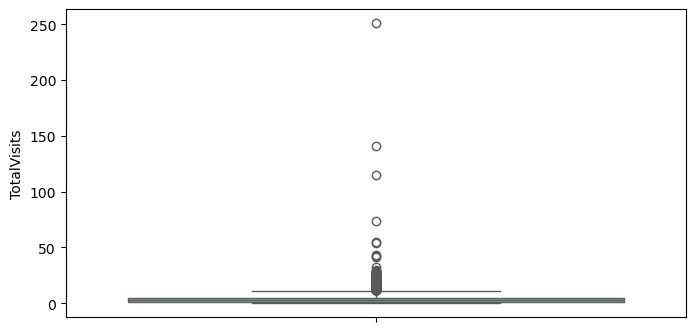

In [41]:
plt.figure(figsize=(8,4))
sns.boxplot(lead.TotalVisits,palette='Set2')
plt.show()

In [42]:
# there are a lot of outliers we can obsere from the above plot
percentiles =lead['TotalVisits'].quantile([0.05,0.95]).values
lead.TotalVisits[(lead.TotalVisits<=percentiles[0])]=percentiles[0]
lead.TotalVisits[(lead.TotalVisits>=percentiles[1])]=percentiles[1]

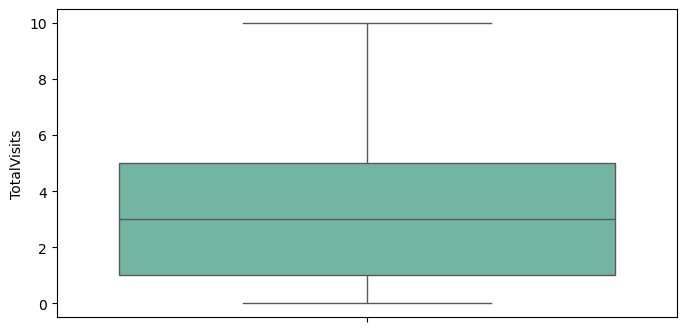

In [43]:
plt.figure(figsize=(8,4))
sns.boxplot(lead.TotalVisits,palette='Set2')
plt.show()

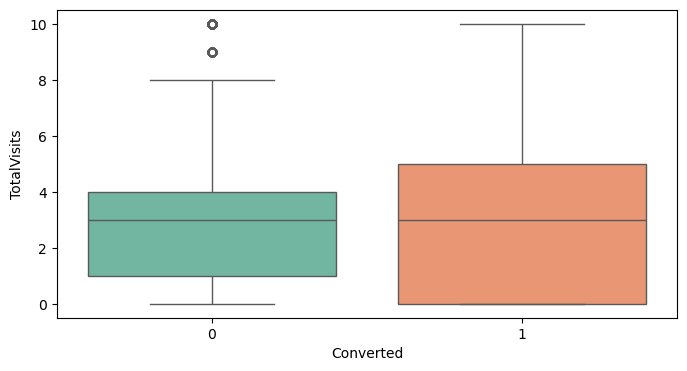

In [44]:
plt.figure(figsize=(8,4))
sns.boxplot(y='TotalVisits',x='Converted',data=lead,palette='Set2')
plt.show()

##### Inferences 
- Medain for both the 0 and 1 are same so no inferences can be made based on this variable

### Total Time Spent on Website

In [45]:
lead['Total Time Spent on Website'].describe()

count    9074.000000
mean      482.887481
std       545.256560
min         0.000000
25%        11.000000
50%       246.000000
75%       922.750000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

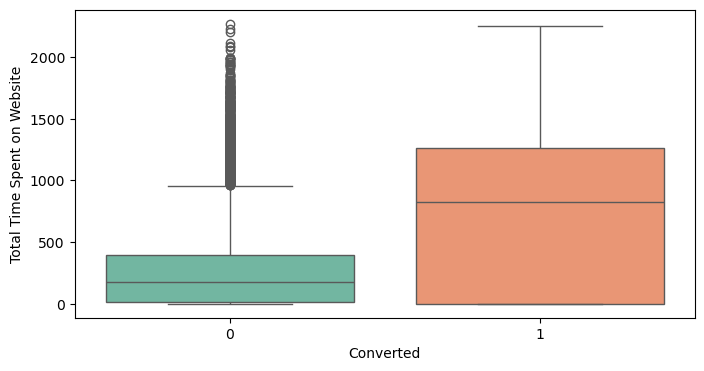

In [46]:
plt.figure(figsize=(8,4))
sns.boxplot(y=lead['Total Time Spent on Website'],x=lead.Converted,palette="Set2")
plt.show()

##### Inferences
- more the time spent on website more the conversion rate

In [47]:
lead['Page Views Per Visit'].describe(percentiles=(0.05,0.25,0.50,0.75,0.90,0.95,0.99))

count    9074.000000
mean        2.370151
std         2.160871
min         0.000000
5%          0.000000
25%         1.000000
50%         2.000000
75%         3.200000
90%         5.000000
95%         6.000000
99%         9.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

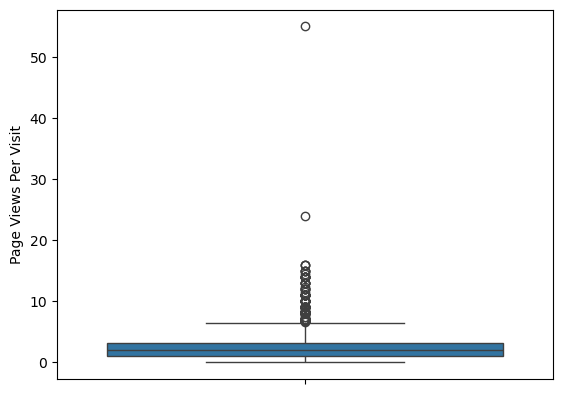

In [48]:
sns.boxplot(lead['Page Views Per Visit'])
plt.show()

In [49]:
# we can observe there are some outliers present
percentiles= lead['Page Views Per Visit'].quantile([0.05,0.95]).values
lead['Page Views Per Visit'][(lead['Page Views Per Visit']<=percentiles[0])]=percentiles[0]
lead['Page Views Per Visit'][(lead['Page Views Per Visit']>=percentiles[1])]=percentiles[1]

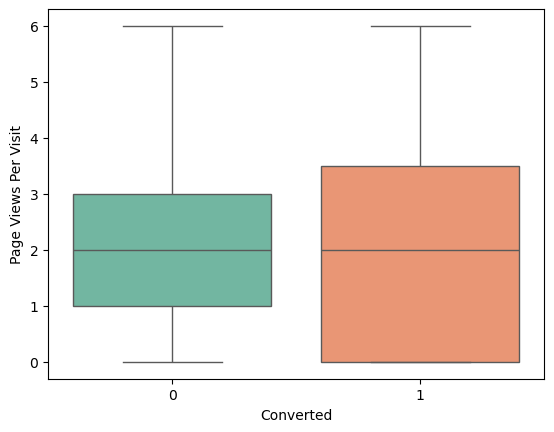

In [50]:
sns.boxplot(x='Converted',y = 'Page Views Per Visit',data=lead,palette='Set2')
plt.show()

##### Inferences 
- Medain for both the 0 and 1 are same so no inferences can be made based on this variable

### Last Activity

In [51]:
lead['Last Activity'].value_counts()

Last Activity
Email Opened                    3432
SMS Sent                        2716
Olark Chat Conversation          972
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    312
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       90
Unsubscribed                      59
Had a Phone Conversation          25
View in browser link Clicked       6
Approached upfront                 5
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: count, dtype: int64

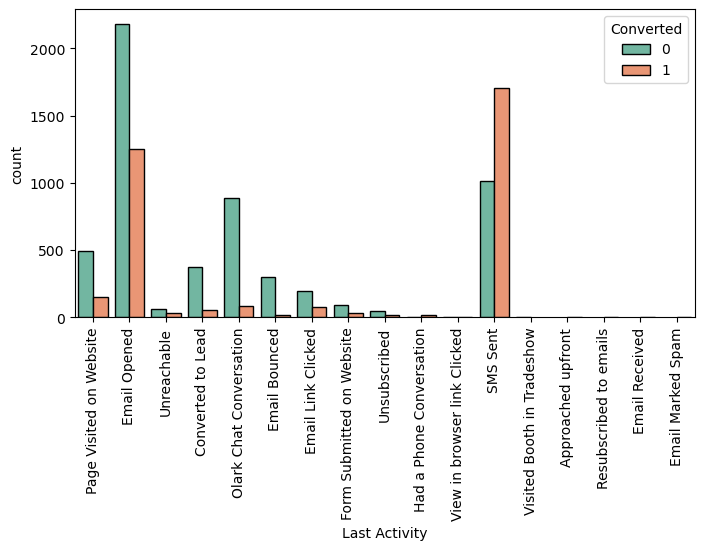

In [52]:
plt.figure(figsize=(8,4))
sns.countplot(x='Last Activity',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation= 90)
plt.show()

In [53]:
lead['Last Activity']=lead['Last Activity'].replace(['Had a Phone Conversation','View in browser link Clicked',
                                                    'Approached upfront','Email Received','Email Marked Spam',
                                                    'Visited Booth in Tradeshow','Resubscribed to emails'],'Other Activities')

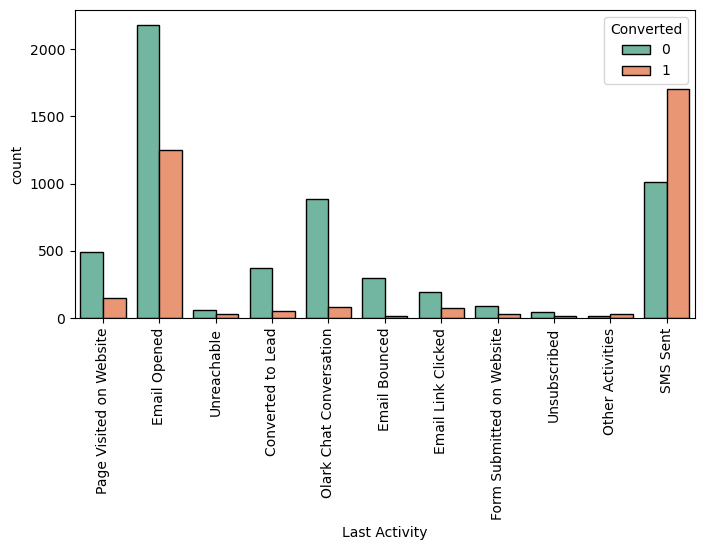

In [54]:
plt.figure(figsize=(8,4))
sns.countplot(x='Last Activity',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation= 90)
plt.show()

#### Inferences
- Conversion rate for Email Opened is ~60%
- SMS Sent has high Conversion rate

### Country

In [55]:
lead.Country.value_counts()

Country
India                   8787
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malays

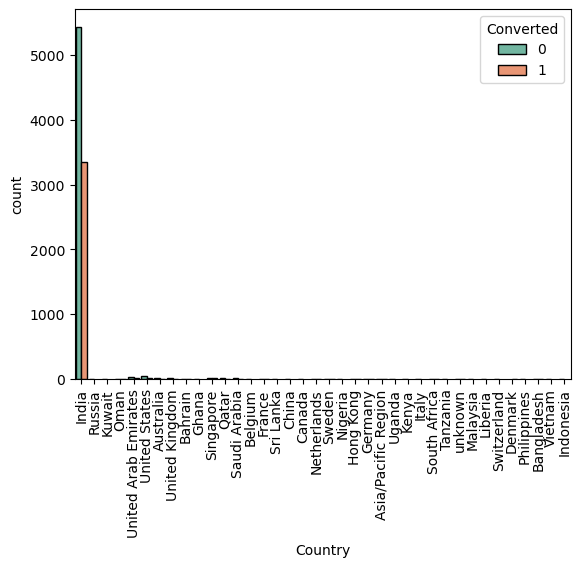

In [56]:
sns.countplot(x='Country',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inference 
- No inference can be drawn as most values are 'India'

In [57]:
lead.head(5)

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0   India     Other Specialization                      Unemployed   
1   India     Other Specialization                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India     Other Specialization                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing          Not Sure   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    City  \
0                                No                        No  Mumbai   
1                                No                        No  Mumbai   
2                                No                        No  Mumbai   
3                                No                        No  Mumbai   
4                                No                        No  Mumbai   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   
2                

### Specialization

In [58]:
lead.Specialization.value_counts()

Specialization
Other Specialization                 3282
Finance Management                    959
Human Resource Management             837
Marketing Management                  823
Operations Management                 499
Business Administration               399
IT Projects Management                366
Supply Chain Management               346
Banking, Investment And Insurance     335
Travel and Tourism                    202
Media and Advertising                 202
International Business                176
Healthcare Management                 156
E-COMMERCE                            111
Hospitality Management                111
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: count, dtype: int64

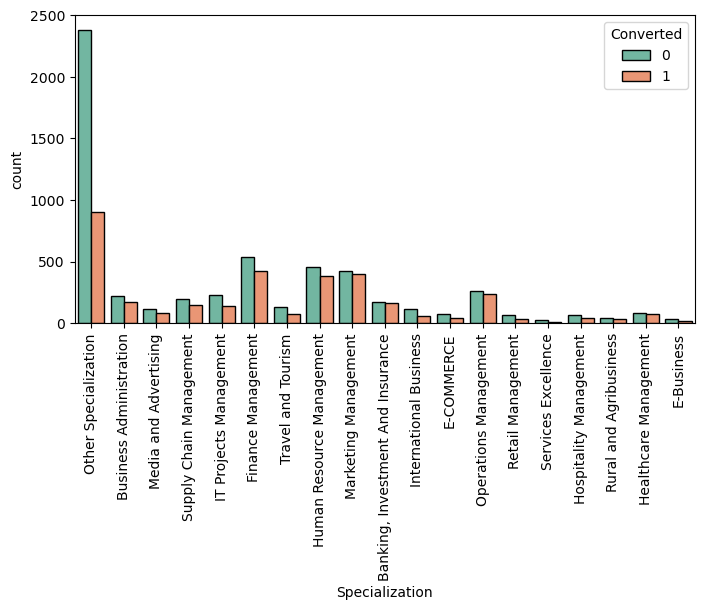

In [59]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'Specialization',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inference 
- No inference can be drawn from the above plot

### What is your current occupation

In [60]:
lead['What is your current occupation'].value_counts()

What is your current occupation
Unemployed              8159
Working Professional     677
Student                  206
Other                     15
Housewife                  9
Businessman                8
Name: count, dtype: int64

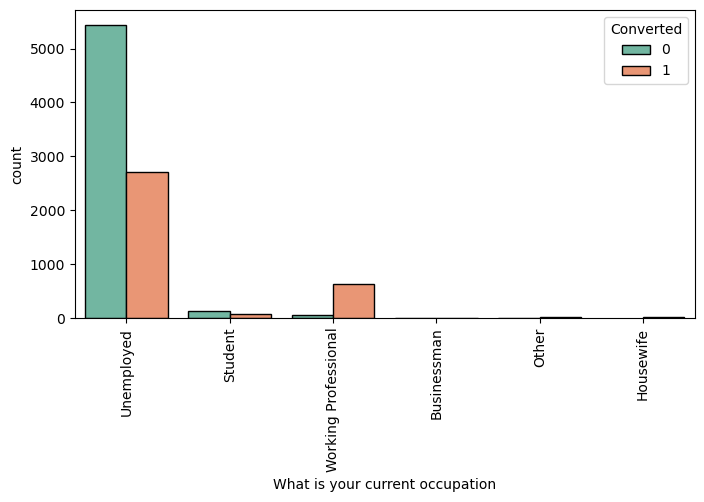

In [61]:
plt.figure(figsize=(8,4))
sns.countplot(x='What is your current occupation',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inferences
- from the above countplot we can say that Unemployed has high count and 30-35% conversion rate and Working Professional has high conversion rate

### What matters most to you in choosing a course

In [62]:
lead['What matters most to you in choosing a course'].value_counts()

What matters most to you in choosing a course
Better Career Prospects      9072
Flexibility & Convenience       1
Other                           1
Name: count, dtype: int64

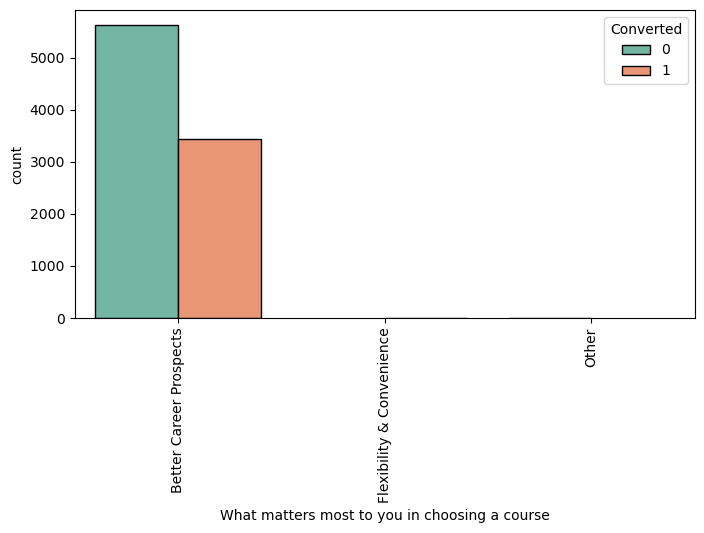

In [63]:
plt.figure(figsize=(8,4))
sns.countplot(x='What matters most to you in choosing a course',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inference 
- No inference can be drawn from the above countplot.

### Columns that we cannot draw any inference
-----------
Search, Magazine, Newspaper Article, X Eduction forums, Newspaper, Digital Advertisement,Through Recommendations, Receive More Updates About Our Courses, Update me on Supply Chain Content, Get updates on DM Content, I agree to pay the amount through cheque, A free copy of Mastering The Interview

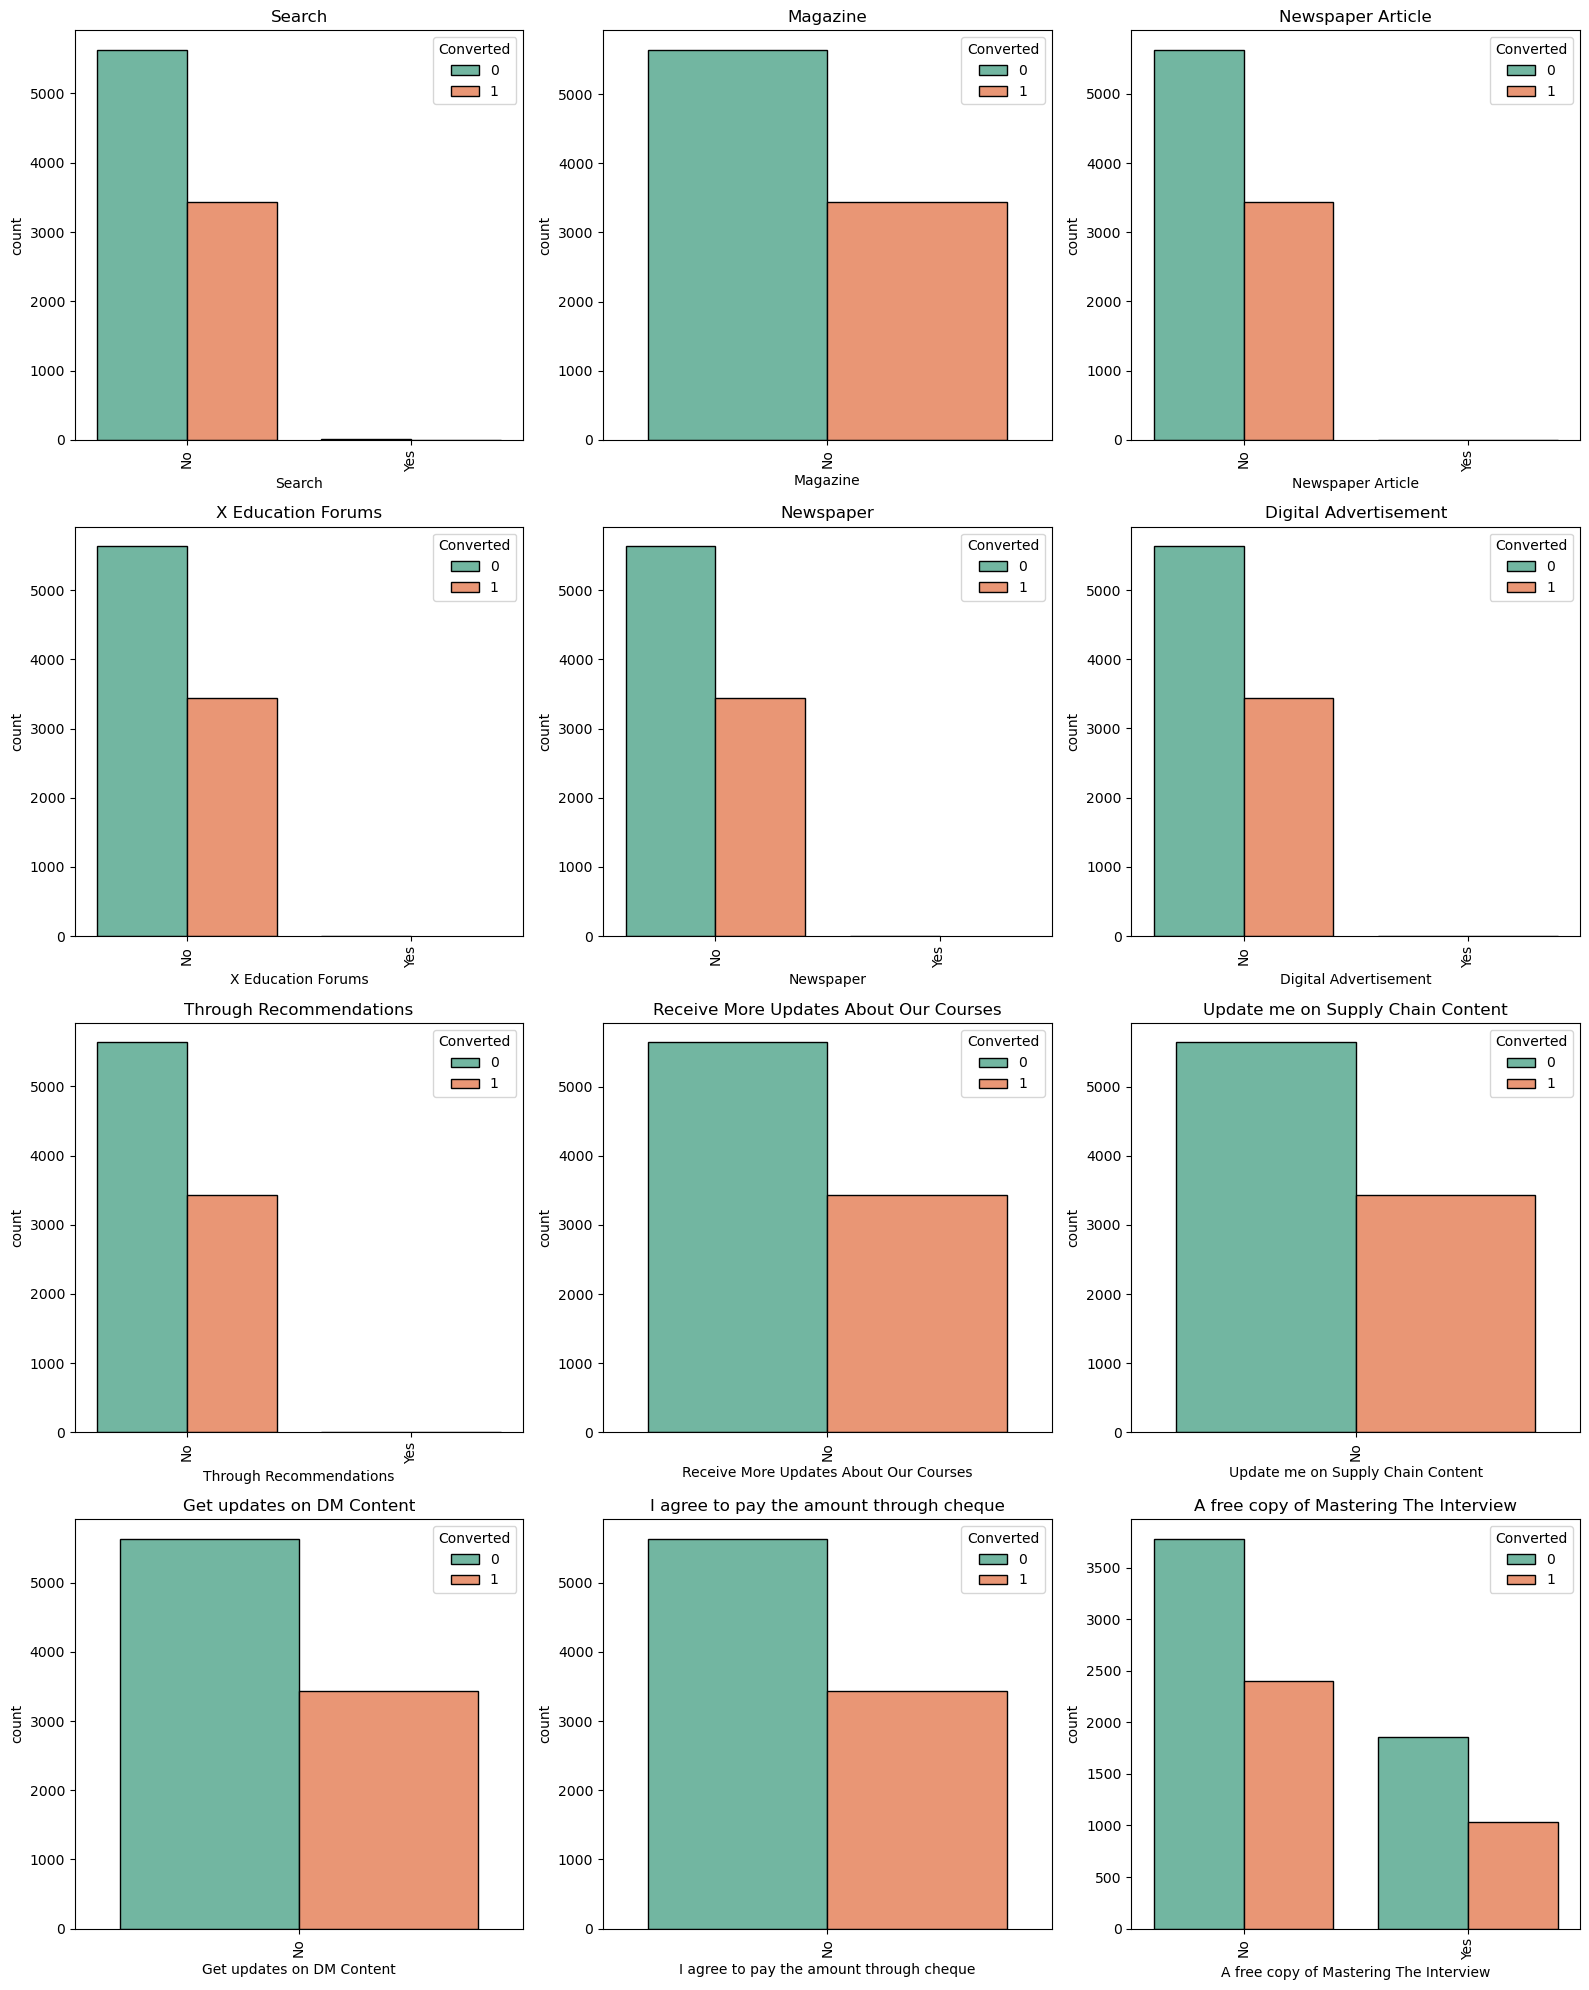

In [64]:
variables = ['Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 
             'Newspaper', 'Digital Advertisement', 'Through Recommendations',
             'Receive More Updates About Our Courses','Update me on Supply Chain Content',
             'Get updates on DM Content','I agree to pay the amount through cheque',
             'A free copy of Mastering The Interview']

n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.countplot(x=var, hue='Converted', data=lead, palette='Set2', edgecolor='black', ax=axes[i])
    axes[i].set_title(var)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

##### Inference 
- No inference can be drawn from the above countplots.

### Tags

In [65]:
lead.Tags.value_counts()

Tags
Will revert after reading the email                  5343
Ringing                                              1187
Interested in other courses                           509
Already a student                                     465
Closed by Horizzon                                    301
switched off                                          240
Busy                                                  185
Lost to EINS                                          172
Not doing further education                           145
Interested  in full time MBA                          116
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    25
in touch with EINS                                     12
Lost to O

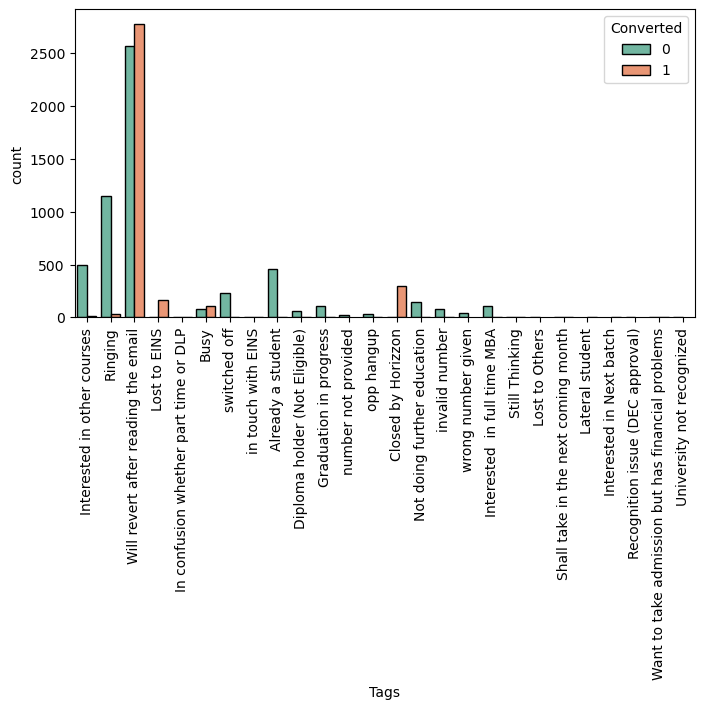

In [66]:
plt.figure(figsize=(8,4))
sns.countplot(x='Tags',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inference
- we need to remove this column before building the model as this variable is assesed by the sales team and this of no use for building a model

### City

In [67]:
lead.City.value_counts()

City
Mumbai                         6752
Thane & Outskirts               745
Other Cities                    680
Other Cities of Maharashtra     446
Other Metro Cities              377
Tier II Cities                   74
Name: count, dtype: int64

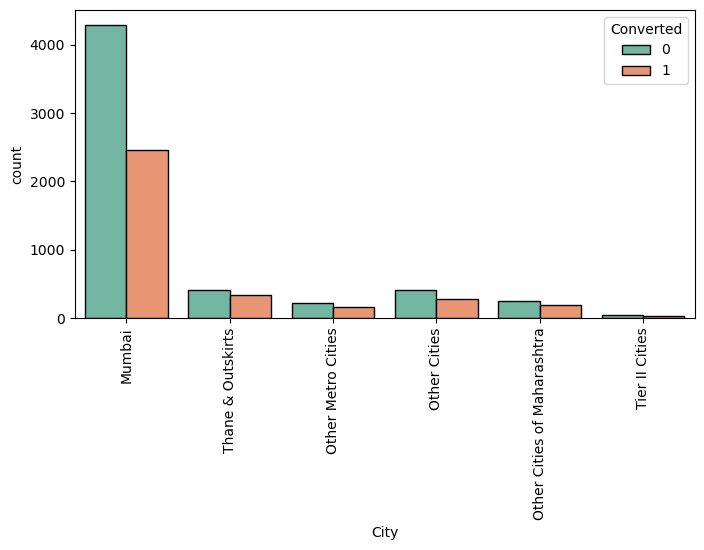

In [68]:
plt.figure(figsize=(8,4))
sns.countplot(x='City',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

##### Inferences
- Mumbai has the conversion rate of ~50%, Remaining values has Considerable conversion rates

### Last Notable Activity

In [69]:
lead['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        3267
Email Opened                    2823
SMS Sent                        2152
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      45
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: count, dtype: int64

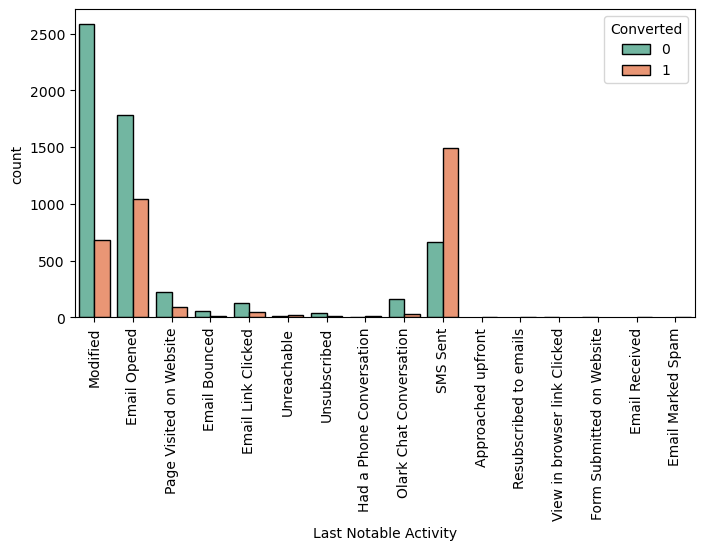

In [70]:
plt.figure(figsize=(8,4))
sns.countplot(x='Last Notable Activity',hue='Converted',data=lead,palette='Set2',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

#### From the above EDA we came to know that some columns doesnot add any information to the Model building so we can drop those columns 

In [71]:
lead=lead.drop(['Lead Number', 'Tags', 'Country', 'Search', 'Magazine', 'Newspaper Article', 
           'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 
           'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 
           'Get updates on DM Content', 'I agree to pay the amount through cheque', 
           'A free copy of Mastering The Interview','What matters most to you in choosing a course'], axis=1)

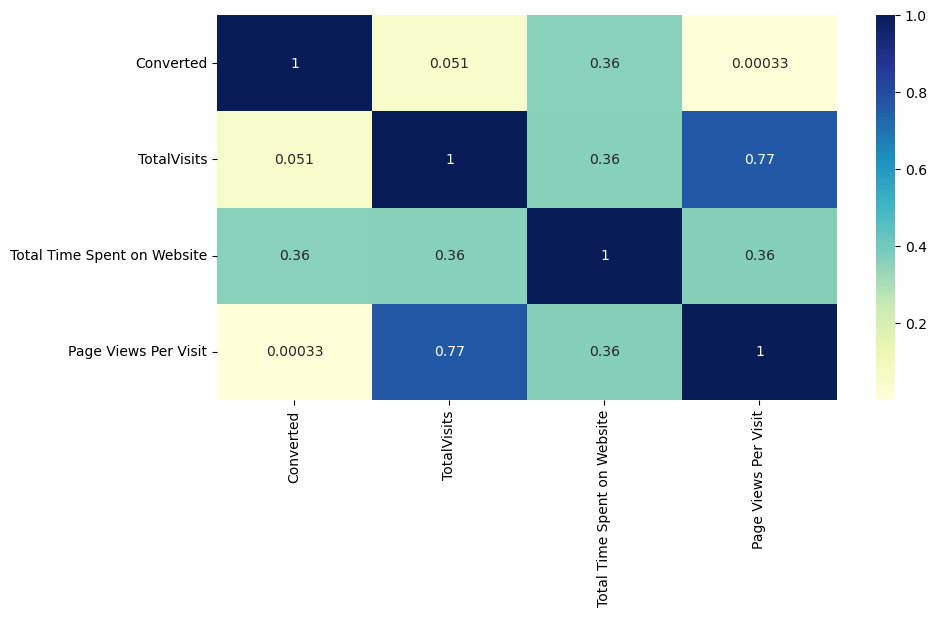

In [72]:
numerical_df = lead.select_dtypes(include=[np.number])

# Correlation between different numerical variables for both the Converted and not-converted cases
conv_corr = numerical_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conv_corr, annot=True, cmap='YlGnBu')
plt.show()

In [73]:
lead.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9074 entries, 0 to 9239
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Prospect ID                      9074 non-null   object 
 1   Lead Origin                      9074 non-null   object 
 2   Lead Source                      9074 non-null   object 
 3   Do Not Email                     9074 non-null   object 
 4   Do Not Call                      9074 non-null   object 
 5   Converted                        9074 non-null   int64  
 6   TotalVisits                      9074 non-null   float64
 7   Total Time Spent on Website      9074 non-null   int64  
 8   Page Views Per Visit             9074 non-null   float64
 9   Last Activity                    9074 non-null   object 
 10  Specialization                   9074 non-null   object 
 11  What is your current occupation  9074 non-null   object 
 12  Lead Quality             

In [74]:
lead.head()

Prospect ID              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

            Specialization What is your current occupation      Lead Quality  \
0     Other Specialization                      Unemployed  Low in Relevance   
1     Other Specialization                      Unemployed          Not Sure   
2  Business Administration                         Student          Might be   
3    Media and Advertising                      Unemployed          Not Sure   
4     Other Specialization                      Unemployed          Might be   

     City Last Notable Activity  
0  Mumbai              Modified  
1  Mumbai          Email Opened  
2  Mumbai          Email Opened  
3  Mumbai              Modified  
4  Mumbai              Modified

### Data Preparation

In [75]:
cols_convert = ['Do Not Email', 'Do Not Call']

for value in cols_convert:
    lead[value]=lead[value].apply(lambda x:1 if x == 'Yes' else 0)
lead.head()

Prospect ID              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852  Landing Page Submission   

      Lead Source  Do Not Email  Do Not Call  Converted  TotalVisits  \
0      Olark Chat             0            0          0          0.0   
1  Organic Search             0            0          0          5.0   
2  Direct Traffic             0            0          1          2.0   
3  Direct Traffic             0            0          0          1.0   
4          Google             0            0          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

            Specialization What is your current occupation      Lead Quality  \
0     Other Specialization                      Unemployed  Low in Relevance   
1     Other Specialization                      Unemployed          Not Sure   
2  Business Administration                         Student          Might be   
3    Media and Advertising                      Unemployed          Not Sure   
4     Other Specialization                      Unemployed          Might be   

     City Last Notable Activity  
0  Mumbai              Modified  
1  Mumbai          Email Opened  
2  Mumbai          Email Opened  
3  Mumbai              Modified  
4  Mumbai              Modified

## Step 4: Dummy Variables Creation

In [76]:
# Creating dummy variables for categorical variables
dummies = pd.get_dummies(lead[['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation',
                             'City','Last Notable Activity']], drop_first=True)
dummies = dummies.astype(int)
dummies.head()


Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Source_Facebook  Lead Source_Google  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     0                   0   
4                        0                     0                   1   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak Website  Last Activity_Email Bounced  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   Last Activity_Email Link Clicked  Last Activity_Email Opened  \
0                                 0                           0   
1                                 0                           1   
2                                 0                           1   
3                                 0                           0   
4                                 0                           0   

   Last Activity_Form Submitted on Website  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
0                                      1                       0   
1                                      0                       0   
2                                      0                       0   
3                                      0                       0   
4                                      0                       0   

   Last Activity_Unreachable  Last Activity_Unsubscribed  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          1                           0   
4                          0                           0   

   Specialization_Business Administration  Specialization_E-Bus

In [77]:
# dropping the original unnecessary columns
lead=lead.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation',
                              'Lead Quality','City','Last Notable Activity'],axis=1)
lead.head()

Prospect ID  Do Not Email  Do Not Call  Converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620             0            0          0   
1  2a272436-5132-4136-86fa-dcc88c88f482             0            0          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a             0            0          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc             0            0          0   
4  3256f628-e534-4826-9d63-4a8b88782852             0            0          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  
0          0.0                            0                   0.0  
1          5.0                          674                   2.5  
2          2.0                         1532                   2.0  
3          1.0                          305                   1.0  
4          2.0                         1428                   1.0

In [78]:
# concatinating dummies and main dataframe
lead=pd.concat([lead,dummies],axis=1)
lead.head()

Prospect ID  Do Not Email  Do Not Call  Converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620             0            0          0   
1  2a272436-5132-4136-86fa-dcc88c88f482             0            0          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a             0            0          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc             0            0          0   
4  3256f628-e534-4826-9d63-4a8b88782852             0            0          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Source_Facebook  Lead Source_Google  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     0                   0   
4                        0                     0                   1   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Welingak Website  Last Activity_Email Bounced  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   Last Activity_Email Link Clicked  Last Activity_Email Opened  \
0                                 0                           0   
1                                 0                           1   
2                                 0                           1   
3                                 0                           0   
4                                 0                           0   

   Last Activity_Form Submitted on Website  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                

## Step 5: Train-Test Split

In [79]:
# Dividing data into test and train sets 
from sklearn.model_selection import train_test_split
# Removing the target variable from the dataframe
X = lead.drop(['Prospect ID','Converted'],axis = 1)
X.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
0             0            0          0.0                            0   
1             0            0          5.0                          674   
2             0            0          2.0                         1532   
3             0            0          1.0                          305   
4             0            0          2.0                         1428   

   Page Views Per Visit  Lead Origin_Landing Page Submission  \
0                   0.0                                    0   
1                   2.5                                    0   
2                   2.0                                    1   
3                   1.0                                    1   
4                   1.0                                    1   

   Lead Origin_Lead Add Form  Lead Origin_Lead Import  Lead Source_Facebook  \
0                          0                        0                     0   
1                          0                        0                     0   
2                          0                        0                     0   
3                          0                        0                     0   
4                          0                        0                     0   

   Lead Source_Google  Lead Source_Olark Chat  Lead Source_Organic Search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   1                       0                           0   

   Lead Source_Others  Lead Source_Reference  Lead Source_Referral Sites  \
0                   0                      0                           0   
1                   0                      0                           0   
2                   0                      0                           0   
3                   0                      0                           0   
4                   0                      0                           0   

   Lead Source_Welingak Website  Last Activity_Email Bounced  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

   Last Activity_Email Link Clicked  Last Activity_Email Opened  \
0                                 0                           0   
1                                 0                           1   
2                                 0                           1   
3                                 0                           0   
4                                 0                           0   

   Last Activity_Form Submitted on Website  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
0                                      1                       0   
1                                      0                       0   
2                                      0            

In [80]:
# putting target variable 
y = lead['Converted']
y

0       0
1       0
2       1
3       0
4       1
       ..
9235    1
9236    0
9237    0
9238    1
9239    1
Name: Converted, Length: 9074, dtype: int64

In [81]:
# splitting data
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

In [82]:
X_train.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
3009             0            0          2.0                          397   
1012             1            0          2.0                          190   
9226             0            0          0.0                            0   
4750             0            0          2.0                         1380   
7987             0            0          5.0                         1584   

      Page Views Per Visit  Lead Origin_Landing Page Submission  \
3009                   2.0                                    1   
1012                   2.0                                    1   
9226                   0.0                                    0   
4750                   2.0                                    1   
7987                   2.5                                    1   

      Lead Origin_Lead Add Form  Lead Origin_Lead Import  \
3009                          0                        0   
1012                          0                        0   
9226                          0                        0   
4750                          0                        0   
7987                          0                        0   

      Lead Source_Facebook  Lead Source_Google  Lead Source_Olark Chat  \
3009                     0                   0                       0   
1012                     0                   0                       0   
9226                     0                   0                       1   
4750                     0                   0                       0   
7987                     0                   0                       0   

      Lead Source_Organic Search  Lead Source_Others  Lead Source_Reference  \
3009                           0                   0                      0   
1012                           0                   0                      0   
9226                           0                   0                      0   
4750                           0                   0                      0   
7987                           0                   0                      0   

      Lead Source_Referral Sites  Lead Source_Welingak Website  \
3009                           0                             0   
1012                           0                             0   
9226                           0                             0   
4750                           0                             0   
7987                           0                             0   

      Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
3009                            0                                 0   
1012                            1                                 0   
9226                            0                                 0   
4750                            0                                 0   
7987                            0                                 0   

      Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
3009                           1                                        0   
1012                           0                                        0   
9226                           0                                        0   
4750                           0                                        0   
7987                           0                                        0   

      Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
3009                                      0                               0   
1012                                      0                               0   
9226                                      0                               0   
4750                                      0                               0   
7987                                      0                               0   

      Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
3009                      

## Step 6: Feature Scaling

In [83]:
from sklearn.preprocessing import StandardScaler
# Standardising Numerical variables
scalar = StandardScaler()
X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]=scalar.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_train.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
3009             0            0    -0.432779                    -0.160255   
1012             1            0    -0.432779                    -0.540048   
9226             0            0    -1.150329                    -0.888650   
4750             0            0    -0.432779                     1.643304   
7987             0            0     0.643547                     2.017593   

      Page Views Per Visit  Lead Origin_Landing Page Submission  \
3009             -0.155018                                    1   
1012             -0.155018                                    1   
9226             -1.265540                                    0   
4750             -0.155018                                    1   
7987              0.122613                                    1   

      Lead Origin_Lead Add Form  Lead Origin_Lead Import  \
3009                          0                        0   
1012                          0                        0   
9226                          0                        0   
4750                          0                        0   
7987                          0                        0   

      Lead Source_Facebook  Lead Source_Google  Lead Source_Olark Chat  \
3009                     0                   0                       0   
1012                     0                   0                       0   
9226                     0                   0                       1   
4750                     0                   0                       0   
7987                     0                   0                       0   

      Lead Source_Organic Search  Lead Source_Others  Lead Source_Reference  \
3009                           0                   0                      0   
1012                           0                   0                      0   
9226                           0                   0                      0   
4750                           0                   0                      0   
7987                           0                   0                      0   

      Lead Source_Referral Sites  Lead Source_Welingak Website  \
3009                           0                             0   
1012                           0                             0   
9226                           0                             0   
4750                           0                             0   
7987                           0                             0   

      Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
3009                            0                                 0   
1012                            1                                 0   
9226                            0                                 0   
4750                            0                                 0   
7987                            0                                 0   

      Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
3009                           1                                        0   
1012                           0                                        0   
9226                           0                                        0   
4750                           0                                        0   
7987                           0                                        0   

      Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
3009                                      0                               0   
1012                                      0                               0   
9226                                      0                               0   
4750                                      0                               0   
7987                                      0                               0   

      Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
3009                      

In [84]:
# checking Lead Conversion rate

converted = (sum(lead.Converted)/len(lead.Converted.index))*100
converted

37.85541106458012

- aprroxmately 38% conversion rate

## Step 7: Checking Correlations

In [85]:
# Correlation between different numerical variables for both the Converted and not-converted cases
numerical_df = lead.select_dtypes(include=[np.number])

conv_corr = numerical_df.corr()

# Create an upper triangular matrix of ones, excluding the diagonal
mask = np.triu(np.ones(conv_corr.shape), k=1).astype(bool)

# Apply the mask to the correlation matrix, keeping only the upper triangle values
upper_triangle = conv_corr.where(mask)

# Stack the upper triangle matrix into a long format, removing NaNs
stacked = upper_triangle.stack()

# Sort the correlations in descending order and get the top 10 highest correlations
top_correlations = stacked.sort_values(ascending=False).head(10)

# Display the top 10 highest correlations
print(top_correlations)

Lead Origin_Lead Import                Lead Source_Facebook                             0.983684
Last Activity_Unsubscribed             Last Notable Activity_Unsubscribed               0.872656
Lead Origin_Lead Add Form              Lead Source_Reference                            0.866191
Last Activity_Email Opened             Last Notable Activity_Email Opened               0.861636
Last Activity_SMS Sent                 Last Notable Activity_SMS Sent                   0.853102
Last Activity_Email Link Clicked       Last Notable Activity_Email Link Clicked         0.800686
TotalVisits                            Page Views Per Visit                             0.766567
Last Activity_Page Visited on Website  Last Notable Activity_Page Visited on Website    0.691811
Do Not Email                           Last Activity_Email Bounced                      0.620041
Last Activity_Unreachable              Last Notable Activity_Unreachable                0.594369
dtype: float64


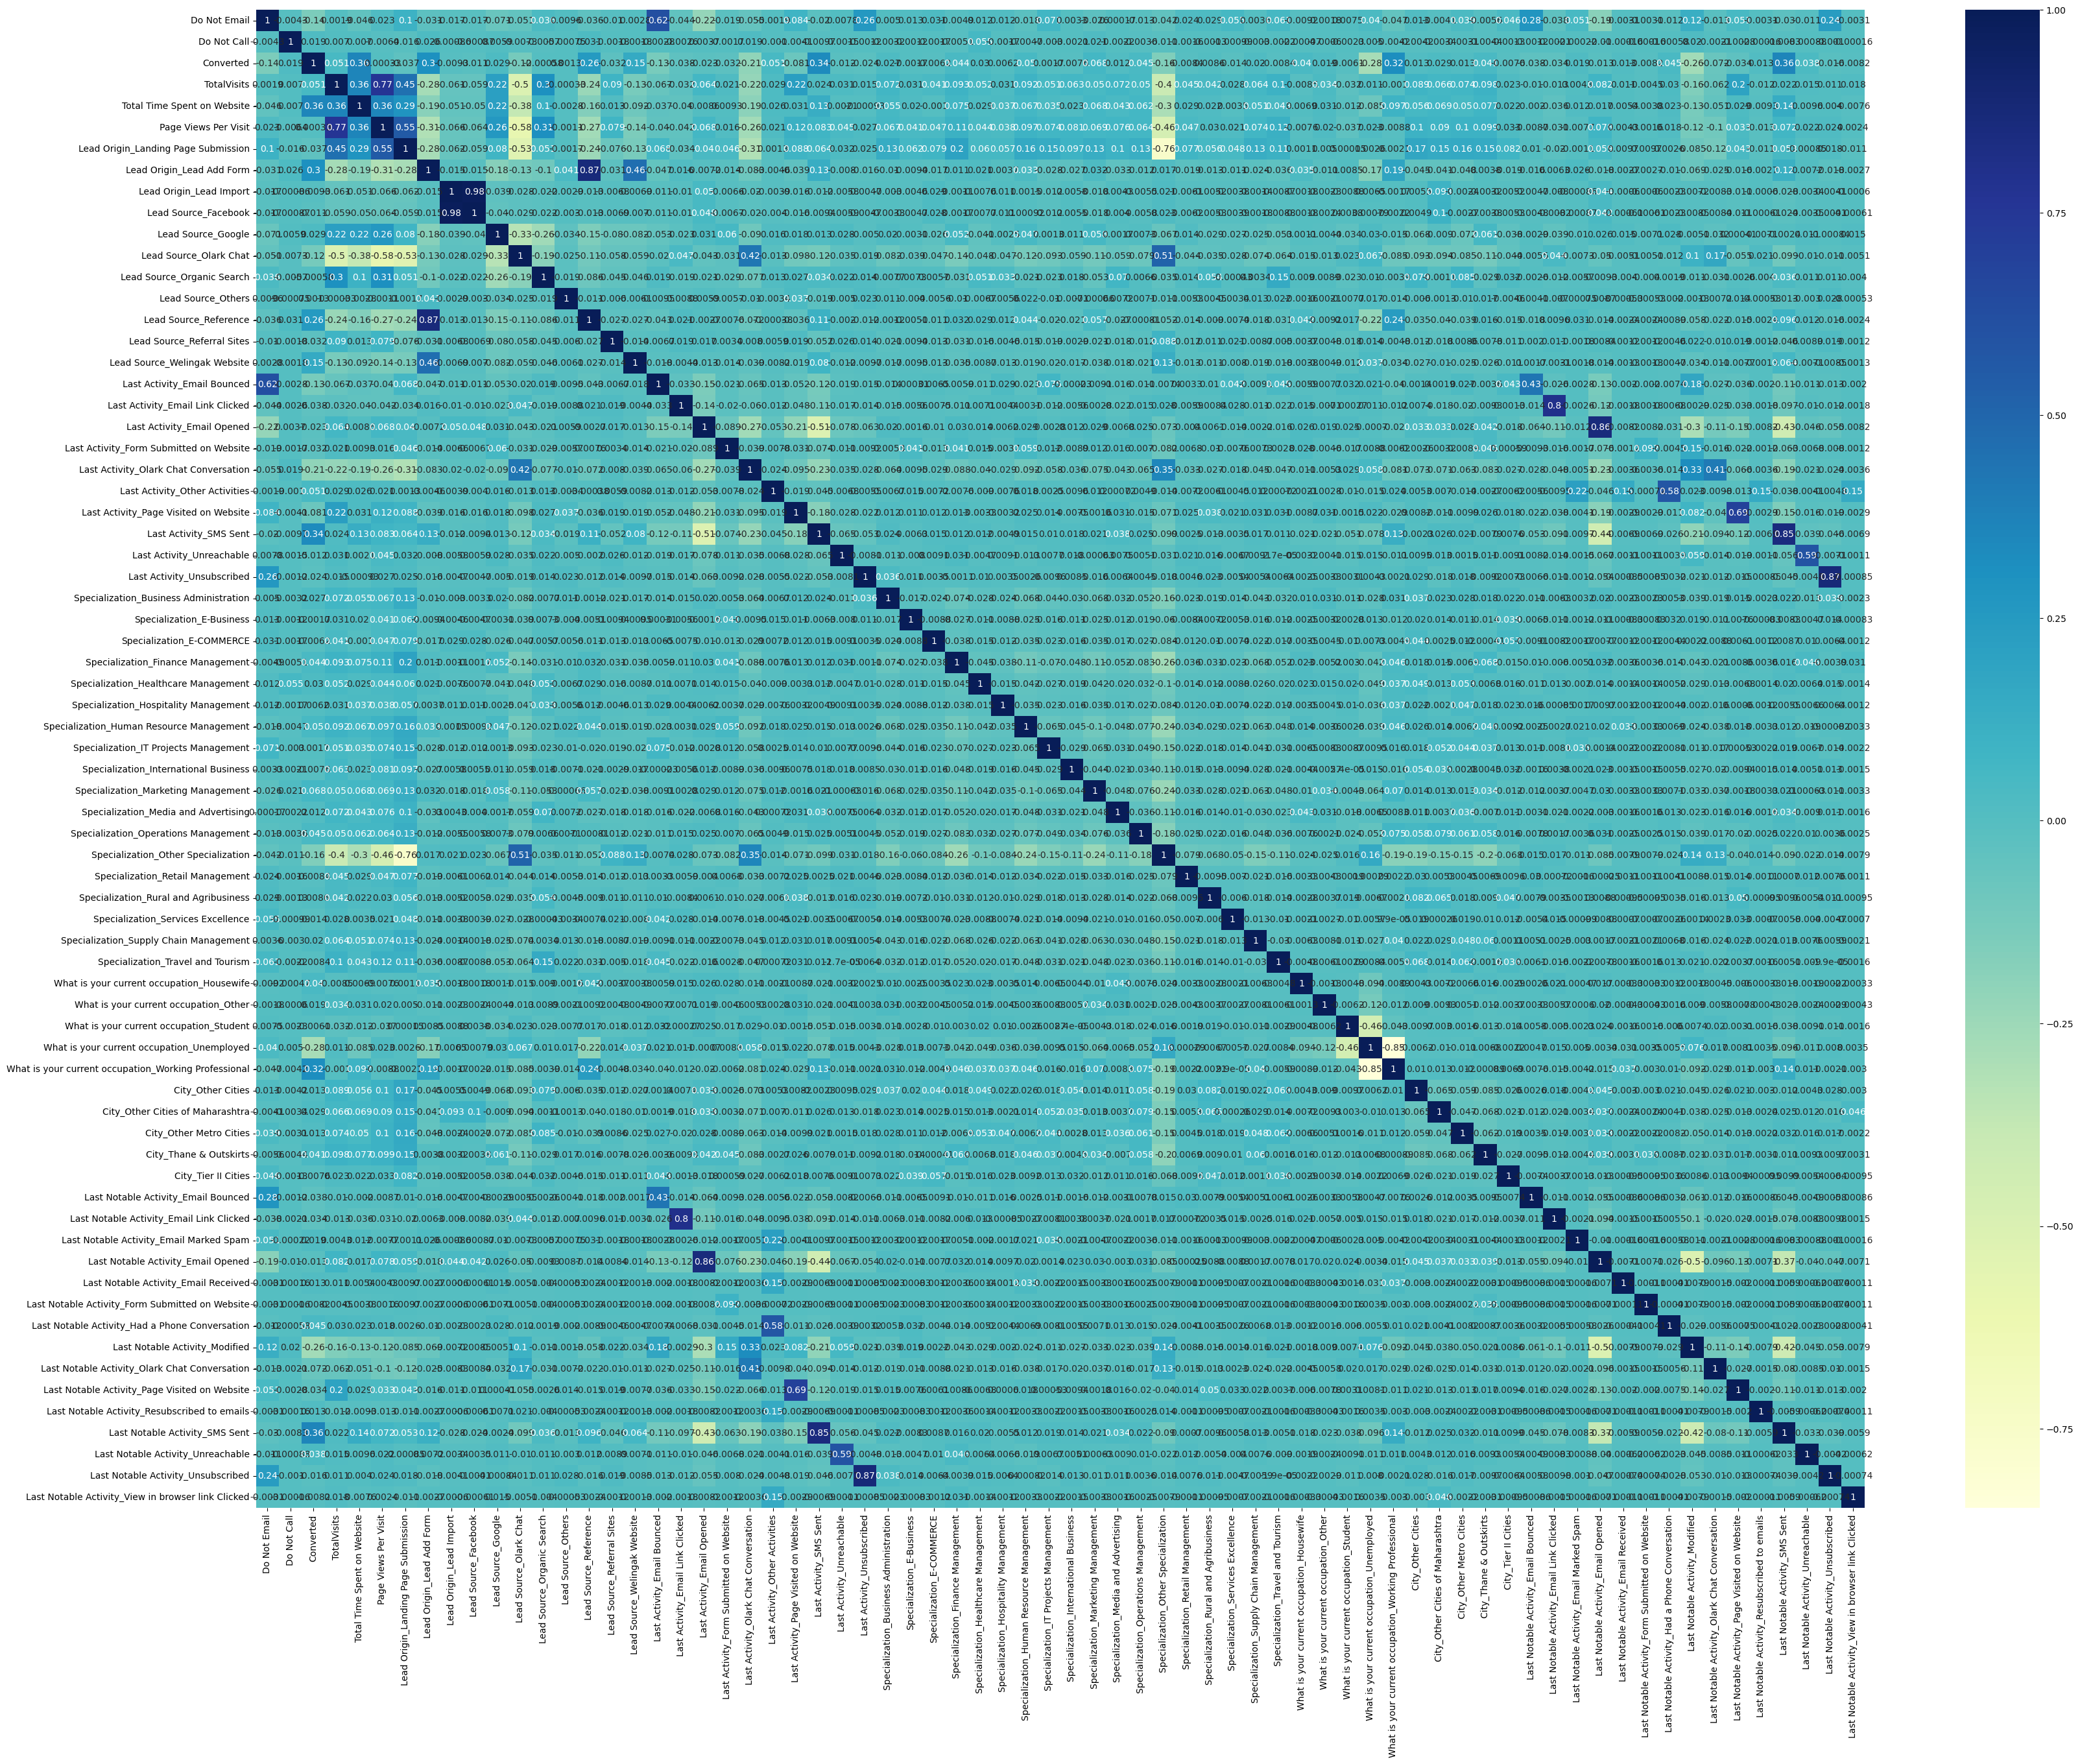

In [86]:
plt.figure(figsize=(40,30))
sns.heatmap(numerical_df.corr(),annot = True,cmap='YlGnBu')
plt.show()

## No point in looking at Heatmap

In [87]:
# Dropping highly correlated features

X_train = X_train.drop(['Lead Source_Facebook','Last Notable Activity_Unsubscribed',
                        'Last Notable Activity_SMS Sent','Last Notable Activity_Email Opened',
                        'Last Notable Activity_Unreachable',
                        'Last Notable Activity_Email Link Clicked',
                        'Last Notable Activity_Page Visited on Website'],axis= 1)


X_test = X_test.drop(['Lead Source_Facebook','Last Notable Activity_Unsubscribed',
                      'Last Notable Activity_SMS Sent','Last Notable Activity_Email Opened',
                      'Last Notable Activity_Unreachable',
                      'Last Notable Activity_Email Link Clicked',
                      'Last Notable Activity_Page Visited on Website'],axis= 1)

In [88]:
numerical_df_train = X_train.select_dtypes(include=[np.number])

conv_corr_train = numerical_df_train.corr()

mask = np.triu(np.ones(conv_corr_train.shape), k=1).astype(bool)

upper_triangle = conv_corr_train.where(mask)

stacked = upper_triangle.stack()

top_correlations = stacked.sort_values(ascending=False).head(10)

print(top_correlations)

Lead Origin_Lead Add Form       Lead Source_Reference                             0.859537
TotalVisits                     Page Views Per Visit                              0.766735
Do Not Email                    Last Activity_Email Bounced                       0.624939
Last Activity_Other Activities  Last Notable Activity_Had a Phone Conversation    0.593057
Page Views Per Visit            Lead Origin_Landing Page Submission               0.550102
Lead Source_Olark Chat          Specialization_Other Specialization               0.505771
Lead Origin_Lead Add Form       Lead Source_Welingak Website                      0.468225
Last Activity_Email Bounced     Last Notable Activity_Email Bounced               0.450911
TotalVisits                     Lead Origin_Landing Page Submission               0.447765
Lead Source_Olark Chat          Last Activity_Olark Chat Conversation             0.419173
dtype: float64


## Step 8: Model Building and Evaluvation

In [89]:
# Building Logistic Regression model
X_train = sm.add_constant(X_train)

In [90]:
logm1 = sm.GLM(y_train, X_train, family=sm.families.Binomial())
logm1_fit = logm1.fit()
logm1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6288
Model Family:                Binomial   Df Model:                           62
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2555.6
Date:                Tue, 18 Jun 2024   Deviance:                       5111.1
Time:                        14:02:04   Pearson chi2:                 6.52e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.4104
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.2512      1.177      0.214      0.831      -2.055       2.557
Do Not Email                                            -1.5587      0.223     -6.977      0.000      -1.997      -1.121
Do Not Call                                             21.6483   3.23e+04      0.001      0.999   -6.32e+04    6.33e+04
TotalVisits                                              0.2620      0.056      4.677      0.000       0.152       0.372
Total Time Spent on Website                              1.1128      0.041     26.846      0.000       1.032       1.194
Page Views Per Visit                                    -0.2950      0.063     -4.704      0.000      -0.418      -0.172
Lead Origin_Landing Page Submission                     -0.9390      0.138     -6.808      0.000      -1.209      -0.669
Lead Origin_Lead Add Form                                1.0775      1.019      1.058      0.290      -0.919       3.074
Lead Origin_Lead Import                                  1.0605      0.493      2.152      0.031       0.095       2.026
Lead Source_Google                                       0.3393      0.098      3.474      0.001       0.148       0.531
Lead Source_Olark Chat                                   1.3093      0.163      8.046      0.000       0.990       1.628
Lead Source_Organic Search                               0.1615      0.133      1.218      0.223      -0.098       0.421
Lead Source_Others                                       0.8666      0.655      1.324      0.186      -0.416       2.149
Lead Source_Reference                                    2.4488      1.044      2.346      0.019       0.403       4.494
Lead Source_Referral Sites                               0.0154      0.356      0.043      0.966      -0.682       0.713
Lead Source_Welingak Website                             4.9763      1.251      3.976      0.000       2.523       7.429
Last Activity_Email Bounced                             -0.2245      0.677     -0.332      0.740      -1.552       1.103
Last Activity_Email Link Clicked                         0.2432      0.313      0.777      0.437      -0.370       0.856
Last Activity_Email Opened                               0.5729      0.240      2.384      0.017       0.102       1.044
Last Activity_Form Submitted on Website                  0.3744      0.403      0.930      0.353      -0.415       1.164
Last Activity_Olark Chat Conversation                   -0.3782      0.288     -1.312      0.189      -0.943       0.187
Last Activity_Other Activities                           2.3656      0.630      3.756      0.000       1.131       3.600
Last Activity_Page Visited on Website                    0

## Feature selection using RFE

In [91]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

from sklearn.feature_selection import RFE

rfe = RFE(estimator=logreg,n_features_to_select=20)
rfe=rfe.fit(X_train,y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('const', False, 35),
 ('Do Not Email', True, 1),
 ('Do Not Call', False, 5),
 ('TotalVisits', False, 15),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 14),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', True, 1),
 ('Lead Source_Google', False, 16),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 26),
 ('Lead Source_Others', False, 17),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral Sites', False, 42),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Email Bounced', False, 7),
 ('Last Activity_Email Link Clicked', False, 43),
 ('Last Activity_Email Opened', False, 13),
 ('Last Activity_Form Submitted on Website', False, 29),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_Other Activities', True, 1),
 ('Last Activity_Page Visited on Website', False, 40),
 ('Last Activity_SMS Sent', True, 1),
 ('Last Activi

In [92]:
col = X_train.columns[rfe.support_]
col

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified'],
      dtype='object')

### Model Assessment using Statsmodel

In [93]:
# Model_2
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6330
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2592.7
Date:                Tue, 18 Jun 2024   Deviance:                       5185.3
Time:                        14:02:09   Pearson chi2:                 6.52e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.4034
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.8609      0.635      1.357      0.175      -0.383       2.105
Do Not Email                                            -1.6777      0.191     -8.801      0.000      -2.051      -1.304
Total Time Spent on Website                              1.1076      0.041     27.186      0.000       1.028       1.187
Lead Origin_Landing Page Submission                     -1.1294      0.129     -8.728      0.000      -1.383      -0.876
Lead Origin_Lead Add Form                                1.5981      0.915      1.746      0.081      -0.196       3.392
Lead Origin_Lead Import                                  0.9014      0.480      1.878      0.060      -0.039       1.842
Lead Source_Olark Chat                                   1.1222      0.124      9.063      0.000       0.879       1.365
Lead Source_Reference                                    1.7673      0.939      1.883      0.060      -0.072       3.607
Lead Source_Welingak Website                             4.2996      1.166      3.688      0.000       2.014       6.585
Last Activity_Olark Chat Conversation                   -0.9392      0.172     -5.459      0.000      -1.276      -0.602
Last Activity_Other Activities                           1.8857      0.538      3.505      0.000       0.831       2.940
Last Activity_SMS Sent                                   1.3458      0.076     17.734      0.000       1.197       1.494
Last Activity_Unreachable                                0.8303      0.313      2.649      0.008       0.216       1.445
Last Activity_Unsubscribed                               1.4091      0.483      2.916      0.004       0.462       2.356
Specialization_Other Specialization                     -1.1442      0.126     -9.082      0.000      -1.391      -0.897
What is your current occupation_Housewife               21.7394   1.53e+04      0.001      0.999   -2.99e+04    2.99e+04
What is your current occupation_Student                 -0.5685      0.671     -0.847      0.397      -1.884       0.747
What is your current occupation_Unemployed              -1.0216      0.632     -1.617      0.106      -2.260       0.216
What is your current occupation_Working Professional     1.6198      0.658      2.461      0.014       0.330       2.910
Last Notable Activity_Had a Phone Conversation           1.4012      1.224      1.145      0.252      -0.997       3.800
Last Notable Activity_Modified                          -0.8930      0.082    -10.923      0.000      -1.053      -0.733
========================================================================================================================
"""

In [94]:
# getting predicted values for y_train
y_train_pred = res.predict(X_train_sm)
y_train_pred

3009    0.187302
1012    0.112171
9226    0.328681
4750    0.867113
7987    0.801744
          ...   
367     0.176805
82      0.932053
8199    0.918491
7077    0.291412
5754    0.282506
Length: 6351, dtype: float64

In [95]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred

array([0.18730203, 0.11217056, 0.32868106, ..., 0.91849117, 0.29141184,
       0.28250594])

In [96]:
# Creating a data frame convert and convert prob
y_train_pred_final = pd.DataFrame({'Convert':y_train.values,'Convert_Prob':y_train_pred})
y_train_pred_final['Prospect ID']= y_train.index
y_train_pred_final.head()

Convert  Convert_Prob  Prospect ID
0        0      0.187302         3009
1        0      0.112171         1012
2        0      0.328681         9226
3        1      0.867113         4750
4        1      0.801744         7987

In [97]:
y_train_pred_final['Predicted']= y_train_pred_final.Convert_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final.head()


Convert  Convert_Prob  Prospect ID  Predicted
0        0      0.187302         3009          0
1        0      0.112171         1012          0
2        0      0.328681         9226          0
3        1      0.867113         4750          1
4        1      0.801744         7987          1

In [98]:
# lets look at accuracy
from sklearn.metrics import accuracy_score
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,
                                      y_train_pred_final.Predicted))


Accuracy Score 0.8176665092111478


### Checking VIF

In [99]:
# creating a function for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def vif(X_train):
    vif_df = pd.DataFrame()
    vif_df['Features']= X_train.columns
    vif_df['VIF']=[variance_inflation_factor(X_train,i) for i in range(X_train.shape[1])]
    vif_df['VIF']=round(vif_df['VIF'],2)
    vif_df=vif_df.sort_values(by='VIF',ascending=False)
    print(vif_df)

vif(X_train[col])
    

                                             Features    VIF
3                           Lead Origin_Lead Add Form  62.65
6                               Lead Source_Reference  48.10
7                        Lead Source_Welingak Website  15.51
16         What is your current occupation_Unemployed  12.46
2                 Lead Origin_Landing Page Submission   7.30
13                Specialization_Other Specialization   4.65
5                              Lead Source_Olark Chat   2.32
19                     Last Notable Activity_Modified   1.87
17  What is your current occupation_Working Profes...   1.82
10                             Last Activity_SMS Sent   1.64
8               Last Activity_Olark Chat Conversation   1.60
9                      Last Activity_Other Activities   1.56
18     Last Notable Activity_Had a Phone Conversation   1.55
1                         Total Time Spent on Website   1.33
15            What is your current occupation_Student   1.31
0                       

In [100]:
## The pvalue for the 'What is your current occupation_Housewife' is very high so we can drop it
col1=col.drop('What is your current occupation_Housewife' )
col

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified'],
      dtype='object')

In [101]:
# Model_3
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6330
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2592.7
Date:                Tue, 18 Jun 2024   Deviance:                       5185.3
Time:                        14:02:10   Pearson chi2:                 6.52e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.4034
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.8609      0.635      1.357      0.175      -0.383       2.105
Do Not Email                                            -1.6777      0.191     -8.801      0.000      -2.051      -1.304
Total Time Spent on Website                              1.1076      0.041     27.186      0.000       1.028       1.187
Lead Origin_Landing Page Submission                     -1.1294      0.129     -8.728      0.000      -1.383      -0.876
Lead Origin_Lead Add Form                                1.5981      0.915      1.746      0.081      -0.196       3.392
Lead Origin_Lead Import                                  0.9014      0.480      1.878      0.060      -0.039       1.842
Lead Source_Olark Chat                                   1.1222      0.124      9.063      0.000       0.879       1.365
Lead Source_Reference                                    1.7673      0.939      1.883      0.060      -0.072       3.607
Lead Source_Welingak Website                             4.2996      1.166      3.688      0.000       2.014       6.585
Last Activity_Olark Chat Conversation                   -0.9392      0.172     -5.459      0.000      -1.276      -0.602
Last Activity_Other Activities                           1.8857      0.538      3.505      0.000       0.831       2.940
Last Activity_SMS Sent                                   1.3458      0.076     17.734      0.000       1.197       1.494
Last Activity_Unreachable                                0.8303      0.313      2.649      0.008       0.216       1.445
Last Activity_Unsubscribed                               1.4091      0.483      2.916      0.004       0.462       2.356
Specialization_Other Specialization                     -1.1442      0.126     -9.082      0.000      -1.391      -0.897
What is your current occupation_Housewife               21.7394   1.53e+04      0.001      0.999   -2.99e+04    2.99e+04
What is your current occupation_Student                 -0.5685      0.671     -0.847      0.397      -1.884       0.747
What is your current occupation_Unemployed              -1.0216      0.632     -1.617      0.106      -2.260       0.216
What is your current occupation_Working Professional     1.6198      0.658      2.461      0.014       0.330       2.910
Last Notable Activity_Had a Phone Conversation           1.4012      1.224      1.145      0.252      -0.997       3.800
Last Notable Activity_Modified                          -0.8930      0.082    -10.923      0.000      -1.053      -0.733
========================================================================================================================
"""

In [102]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.18730203, 0.11217056, 0.32868106, ..., 0.91849117, 0.29141184,
       0.28250594])

In [103]:
# Updating the dataframe
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x:1 if x>0.5 else 0)
y_train_pred_final


Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.187302         3009          0
1           0      0.112171         1012          0
2           0      0.328681         9226          0
3           1      0.867113         4750          1
4           1      0.801744         7987          1
...       ...           ...          ...        ...
6346        0      0.176805          367          0
6347        1      0.932053           82          1
6348        0      0.918491         8199          1
6349        0      0.291412         7077          0
6350        0      0.282506         5754          0

[6351 rows x 4 columns]

In [104]:
# checking accuracy
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.8176665092111478


- There is no significant difference in Accuracy

In [105]:
# checking vif values
vif(X_train[col])

                                             Features    VIF
3                           Lead Origin_Lead Add Form  62.65
6                               Lead Source_Reference  48.10
7                        Lead Source_Welingak Website  15.51
16         What is your current occupation_Unemployed  12.46
2                 Lead Origin_Landing Page Submission   7.30
13                Specialization_Other Specialization   4.65
5                              Lead Source_Olark Chat   2.32
19                     Last Notable Activity_Modified   1.87
17  What is your current occupation_Working Profes...   1.82
10                             Last Activity_SMS Sent   1.64
8               Last Activity_Olark Chat Conversation   1.60
9                      Last Activity_Other Activities   1.56
18     Last Notable Activity_Had a Phone Conversation   1.55
1                         Total Time Spent on Website   1.33
15            What is your current occupation_Student   1.31
0                       

In [106]:
# Droppig the column with high pvalue
col1=col1.drop('Last Notable Activity_Had a Phone Conversation')
col1

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [107]:
#Model_4
X_train_sm=sm.add_constant(X_train[col1])
logm4 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6332
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2595.4
Date:                Tue, 18 Jun 2024   Deviance:                       5190.8
Time:                        14:02:10   Pearson chi2:                 6.52e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4029
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.3414      0.590      2.274      0.023       0.185       2.498
Do Not Email                                            -1.6843      0.191     -8.820      0.000      -2.059      -1.310
Total Time Spent on Website                              1.1054      0.041     27.161      0.000       1.026       1.185
Lead Origin_Landing Page Submission                     -1.1233      0.129     -8.691      0.000      -1.377      -0.870
Lead Origin_Lead Add Form                                1.5996      0.915      1.747      0.081      -0.195       3.394
Lead Origin_Lead Import                                  0.9020      0.480      1.880      0.060      -0.039       1.843
Lead Source_Olark Chat                                   1.1202      0.124      9.045      0.000       0.877       1.363
Lead Source_Reference                                    1.7700      0.939      1.886      0.059      -0.070       3.610
Lead Source_Welingak Website                             4.3012      1.166      3.689      0.000       2.016       6.587
Last Activity_Olark Chat Conversation                   -0.9352      0.172     -5.432      0.000      -1.273      -0.598
Last Activity_Other Activities                           2.2393      0.463      4.833      0.000       1.331       3.147
Last Activity_SMS Sent                                   1.3444      0.076     17.719      0.000       1.196       1.493
Last Activity_Unreachable                                0.8293      0.314      2.642      0.008       0.214       1.444
Last Activity_Unsubscribed                               1.4141      0.483      2.927      0.003       0.467       2.361
Specialization_Other Specialization                     -1.1446      0.126     -9.092      0.000      -1.391      -0.898
What is your current occupation_Student                 -1.0502      0.627     -1.675      0.094      -2.279       0.179
What is your current occupation_Unemployed              -1.5018      0.585     -2.568      0.010      -2.648      -0.356
What is your current occupation_Working Professional     1.1355      0.613      1.852      0.064      -0.066       2.337
Last Notable Activity_Modified                          -0.9020      0.082    -11.050      0.000      -1.062      -0.742
========================================================================================================================
"""

In [108]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.18832595, 0.11182737, 0.32636434, ..., 0.9188422 , 0.29244979,
       0.28147815])

In [109]:
# updating the df
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x:1 if x>0.5 else 0)
y_train_pred_final

Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.188326         3009          0
1           0      0.111827         1012          0
2           0      0.326364         9226          0
3           1      0.867282         4750          1
4           1      0.800414         7987          1
...       ...           ...          ...        ...
6346        0      0.175296          367          0
6347        1      0.931811           82          1
6348        0      0.918842         8199          1
6349        0      0.292450         7077          0
6350        0      0.281478         5754          0

[6351 rows x 4 columns]

In [110]:
# cheking accuracy score
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.817509053692332


- No significant difference in Accuracy Score

In [111]:
# Checking vif
vif(X_train[col1])

                                             Features    VIF
3                           Lead Origin_Lead Add Form  62.65
6                               Lead Source_Reference  48.09
7                        Lead Source_Welingak Website  15.51
15         What is your current occupation_Unemployed  12.35
2                 Lead Origin_Landing Page Submission   7.24
13                Specialization_Other Specialization   4.63
5                              Lead Source_Olark Chat   2.32
17                     Last Notable Activity_Modified   1.87
16  What is your current occupation_Working Profes...   1.81
10                             Last Activity_SMS Sent   1.64
8               Last Activity_Olark Chat Conversation   1.60
1                         Total Time Spent on Website   1.33
14            What is your current occupation_Student   1.30
0                                        Do Not Email   1.21
12                         Last Activity_Unsubscribed   1.08
4                       

In [112]:
# Droppig the column with high pvalue
col1 = col1.drop('What is your current occupation_Student')
print(len(col1))
print('------------------------------')
col1

17
------------------------------


Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [113]:
# Model_5
X_train_sm = sm.add_constant(X_train[col1])
logm5=sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6333
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2596.9
Date:                Tue, 18 Jun 2024   Deviance:                       5193.7
Time:                        14:02:10   Pearson chi2:                 6.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4027
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.4540      0.240      1.892      0.059      -0.016       0.924
Do Not Email                                            -1.6806      0.191     -8.812      0.000      -2.054      -1.307
Total Time Spent on Website                              1.1063      0.041     27.190      0.000       1.027       1.186
Lead Origin_Landing Page Submission                     -1.1367      0.129     -8.812      0.000      -1.390      -0.884
Lead Origin_Lead Add Form                                1.5936      0.915      1.742      0.082      -0.200       3.387
Lead Origin_Lead Import                                  0.8948      0.480      1.864      0.062      -0.046       1.836
Lead Source_Olark Chat                                   1.1149      0.124      9.010      0.000       0.872       1.357
Lead Source_Reference                                    1.7767      0.938      1.894      0.058      -0.062       3.616
Lead Source_Welingak Website                             4.3058      1.166      3.694      0.000       2.021       6.591
Last Activity_Olark Chat Conversation                   -0.9367      0.172     -5.447      0.000      -1.274      -0.600
Last Activity_Other Activities                           2.2380      0.463      4.829      0.000       1.330       3.146
Last Activity_SMS Sent                                   1.3431      0.076     17.697      0.000       1.194       1.492
Last Activity_Unreachable                                0.8325      0.313      2.659      0.008       0.219       1.446
Last Activity_Unsubscribed                               1.4100      0.483      2.918      0.004       0.463       2.357
Specialization_Other Specialization                     -1.1566      0.126     -9.201      0.000      -1.403      -0.910
What is your current occupation_Unemployed              -0.6020      0.213     -2.826      0.005      -1.019      -0.184
What is your current occupation_Working Professional     2.0341      0.283      7.180      0.000       1.479       2.589
Last Notable Activity_Modified                          -0.8994      0.082    -11.027      0.000      -1.059      -0.740
========================================================================================================================
"""

In [114]:
y_train_pred=res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.18815901, 0.11072853, 0.32538268, ..., 0.91876012, 0.32427182,
       0.28199784])

In [115]:
#updating the df
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted'] = y_train_pred_final.Convert_Prob.map(lambda x: 1 if x>0.5 else 0)
y_train_pred_final


Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.188159         3009          0
1           0      0.110729         1012          0
2           0      0.325383         9226          0
3           1      0.867178         4750          1
4           1      0.800729         7987          1
...       ...           ...          ...        ...
6346        0      0.175797          367          0
6347        1      0.932132           82          1
6348        0      0.918760         8199          1
6349        0      0.324272         7077          0
6350        0      0.281998         5754          0

[6351 rows x 4 columns]

In [116]:
# Checking Accuracy Score
print('Accuracy Score', accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.8176665092111478


- No Significant change in the accuracy

In [117]:
#checking Vifs
vif(X_train[col1])

                                             Features    VIF
3                           Lead Origin_Lead Add Form  62.59
6                               Lead Source_Reference  48.08
7                        Lead Source_Welingak Website  15.51
14         What is your current occupation_Unemployed   9.75
2                 Lead Origin_Landing Page Submission   5.76
13                Specialization_Other Specialization   4.00
5                              Lead Source_Olark Chat   2.24
16                     Last Notable Activity_Modified   1.86
15  What is your current occupation_Working Profes...   1.66
10                             Last Activity_SMS Sent   1.64
8               Last Activity_Olark Chat Conversation   1.60
1                         Total Time Spent on Website   1.32
0                                        Do Not Email   1.21
12                         Last Activity_Unsubscribed   1.08
4                             Lead Origin_Lead Import   1.03
11                      

In [118]:
col1 = col1.drop('Lead Origin_Lead Add Form')
print(len(col1))
print('_________________')
col1

16
_________________


Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Source_Olark Chat', 'Lead Source_Reference',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [119]:
# Model_6
X_train_sm = sm.add_constant(X_train[col1])
logm6 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6334
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2598.5
Date:                Tue, 18 Jun 2024   Deviance:                       5197.1
Time:                        14:02:11   Pearson chi2:                 6.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4023
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.4707      0.240      1.962      0.050       0.001       0.941
Do Not Email                                            -1.6823      0.191     -8.820      0.000      -2.056      -1.308
Total Time Spent on Website                              1.1042      0.041     27.184      0.000       1.025       1.184
Lead Origin_Landing Page Submission                     -1.1549      0.129     -8.973      0.000      -1.407      -0.903
Lead Origin_Lead Import                                  0.8782      0.480      1.828      0.067      -0.063       1.820
Lead Source_Olark Chat                                   1.1081      0.123      8.974      0.000       0.866       1.350
Lead Source_Reference                                    3.3554      0.243     13.813      0.000       2.879       3.832
Lead Source_Welingak Website                             5.8899      0.730      8.072      0.000       4.460       7.320
Last Activity_Olark Chat Conversation                   -0.9412      0.172     -5.474      0.000      -1.278      -0.604
Last Activity_Other Activities                           2.2340      0.463      4.821      0.000       1.326       3.142
Last Activity_SMS Sent                                   1.3431      0.076     17.701      0.000       1.194       1.492
Last Activity_Unreachable                                0.8294      0.313      2.649      0.008       0.216       1.443
Last Activity_Unsubscribed                               1.4084      0.483      2.915      0.004       0.462       2.355
Specialization_Other Specialization                     -1.1683      0.126     -9.302      0.000      -1.415      -0.922
What is your current occupation_Unemployed              -0.5990      0.213     -2.812      0.005      -1.017      -0.181
What is your current occupation_Working Professional     2.0339      0.283      7.178      0.000       1.478       2.589
Last Notable Activity_Modified                          -0.8998      0.082    -11.037      0.000      -1.060      -0.740
========================================================================================================================
"""

In [120]:
y_train_pred=res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.18843957, 0.10935719, 0.32594846, ..., 0.91838678, 0.32397098,
       0.28176261])

In [121]:
# updating the dataframe
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final

Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.188440         3009          0
1           0      0.109357         1012          0
2           0      0.325948         9226          0
3           1      0.866971         4750          1
4           1      0.800260         7987          1
...       ...           ...          ...        ...
6346        0      0.176725          367          0
6347        1      0.932853           82          1
6348        0      0.918387         8199          1
6349        0      0.323971         7077          0
6350        0      0.281763         5754          0

[6351 rows x 4 columns]

In [122]:
# Checking Accuracy Score
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.817509053692332


In [123]:
vif(X_train[col1])

                                             Features   VIF
13         What is your current occupation_Unemployed  9.72
2                 Lead Origin_Landing Page Submission  5.74
12                Specialization_Other Specialization  3.99
4                              Lead Source_Olark Chat  2.24
15                     Last Notable Activity_Modified  1.86
14  What is your current occupation_Working Profes...  1.65
9                              Last Activity_SMS Sent  1.64
7               Last Activity_Olark Chat Conversation  1.60
5                               Lead Source_Reference  1.46
1                         Total Time Spent on Website  1.32
0                                        Do Not Email  1.21
6                        Lead Source_Welingak Website  1.11
11                         Last Activity_Unsubscribed  1.08
3                             Lead Origin_Lead Import  1.03
10                          Last Activity_Unreachable  1.02
8                      Last Activity_Oth

In [124]:
# Dropping the column with high vif value
col1 = col1.drop('What is your current occupation_Unemployed')

In [125]:
print(len(col1))
col1

15


Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Source_Olark Chat', 'Lead Source_Reference',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [126]:
# Model_7
X_train_sm = sm.add_constant(X_train[col1])
logm7 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2602.4
Date:                Tue, 18 Jun 2024   Deviance:                       5204.8
Time:                        14:02:11   Pearson chi2:                 6.54e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4016
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.0991      0.127     -0.779      0.436      -0.349       0.150
Do Not Email                                            -1.6784      0.191     -8.791      0.000      -2.053      -1.304
Total Time Spent on Website                              1.1043      0.041     27.203      0.000       1.025       1.184
Lead Origin_Landing Page Submission                     -1.1596      0.129     -9.003      0.000      -1.412      -0.907
Lead Origin_Lead Import                                  0.8594      0.480      1.790      0.074      -0.082       1.801
Lead Source_Olark Chat                                   1.1135      0.123      9.017      0.000       0.871       1.356
Lead Source_Reference                                    3.3671      0.243     13.879      0.000       2.892       3.843
Lead Source_Welingak Website                             5.8814      0.730      8.061      0.000       4.451       7.311
Last Activity_Olark Chat Conversation                   -0.9328      0.172     -5.432      0.000      -1.269      -0.596
Last Activity_Other Activities                           2.2158      0.464      4.779      0.000       1.307       3.124
Last Activity_SMS Sent                                   1.3279      0.076     17.577      0.000       1.180       1.476
Last Activity_Unreachable                                0.8155      0.312      2.612      0.009       0.204       1.427
Last Activity_Unsubscribed                               1.3828      0.483      2.862      0.004       0.436       2.330
Specialization_Other Specialization                     -1.1805      0.126     -9.385      0.000      -1.427      -0.934
What is your current occupation_Working Professional     2.6136      0.195     13.411      0.000       2.232       2.996
Last Notable Activity_Modified                          -0.9065      0.081    -11.125      0.000      -1.066      -0.747
========================================================================================================================
"""

In [127]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.19221494, 0.10906738, 0.32605861, ..., 0.91938728, 0.21247648,
       0.28540292])

In [128]:
#updating the df
y_train_pred_final['Convert_Prob']= y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final

Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.192215         3009          0
1           0      0.109067         1012          0
2           0      0.326059         9226          0
3           1      0.868056         4750          1
4           1      0.800705         7987          1
...       ...           ...          ...        ...
6346        0      0.178241          367          0
6347        1      0.933806           82          1
6348        0      0.919387         8199          1
6349        0      0.212476         7077          0
6350        0      0.285403         5754          0

[6351 rows x 4 columns]

In [129]:
# checking Accuracy Score
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.8184537868052275


In [130]:
# checking vifs
vif(X_train[col1])

                                             Features   VIF
12                Specialization_Other Specialization  2.17
4                              Lead Source_Olark Chat  2.04
14                     Last Notable Activity_Modified  1.79
2                 Lead Origin_Landing Page Submission  1.71
7               Last Activity_Olark Chat Conversation  1.60
9                              Last Activity_SMS Sent  1.57
1                         Total Time Spent on Website  1.30
5                               Lead Source_Reference  1.24
0                                        Do Not Email  1.21
13  What is your current occupation_Working Profes...  1.19
6                        Lead Source_Welingak Website  1.09
11                         Last Activity_Unsubscribed  1.08
10                          Last Activity_Unreachable  1.02
3                             Lead Origin_Lead Import  1.01
8                      Last Activity_Other Activities  1.01


In [131]:
# Dropping the value having high pvalue
col1 = col1.drop('Lead Origin_Lead Import')
print(len(col1))
col1

14


Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Last Activity_Unsubscribed',
       'Specialization_Other Specialization',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [132]:
# Model_8
X_train_sm = sm.add_constant(X_train[col1])
logm8 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm8.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2603.9
Date:                Tue, 18 Jun 2024   Deviance:                       5207.7
Time:                        14:02:11   Pearson chi2:                 6.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4013
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.0605      0.126     -0.482      0.630      -0.307       0.186
Do Not Email                                            -1.6800      0.191     -8.802      0.000      -2.054      -1.306
Total Time Spent on Website                              1.0973      0.040     27.208      0.000       1.018       1.176
Lead Origin_Landing Page Submission                     -1.1937      0.128     -9.356      0.000      -1.444      -0.944
Lead Source_Olark Chat                                   1.0888      0.123      8.886      0.000       0.849       1.329
Lead Source_Reference                                    3.3345      0.242     13.786      0.000       2.860       3.809
Lead Source_Welingak Website                             5.8585      0.729      8.031      0.000       4.429       7.288
Last Activity_Olark Chat Conversation                   -0.9378      0.172     -5.462      0.000      -1.274      -0.601
Last Activity_Other Activities                           2.2071      0.463      4.765      0.000       1.299       3.115
Last Activity_SMS Sent                                   1.3253      0.075     17.554      0.000       1.177       1.473
Last Activity_Unreachable                                0.8083      0.312      2.590      0.010       0.197       1.420
Last Activity_Unsubscribed                               1.3789      0.483      2.857      0.004       0.433       2.325
Specialization_Other Specialization                     -1.2012      0.126     -9.564      0.000      -1.447      -0.955
What is your current occupation_Working Professional     2.6136      0.195     13.418      0.000       2.232       2.995
Last Notable Activity_Modified                          -0.9066      0.081    -11.130      0.000      -1.066      -0.747
========================================================================================================================
"""

In [133]:
y_train_pred=res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.19308876, 0.107703  , 0.32532443, ..., 0.91855174, 0.21328478,
       0.2847021 ])

In [134]:
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final


Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.193089         3009          0
1           0      0.107703         1012          0
2           0      0.325324         9226          0
3           1      0.866953         4750          1
4           1      0.798741         7987          1
...       ...           ...          ...        ...
6346        0      0.180248          367          0
6347        1      0.935034           82          1
6348        0      0.918552         8199          1
6349        0      0.213285         7077          0
6350        0      0.284702         5754          0

[6351 rows x 4 columns]

In [135]:
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.8182963312864115


In [136]:
vif(X_train[col1])

                                             Features   VIF
11                Specialization_Other Specialization  2.17
3                              Lead Source_Olark Chat  2.03
13                     Last Notable Activity_Modified  1.79
2                 Lead Origin_Landing Page Submission  1.71
6               Last Activity_Olark Chat Conversation  1.59
8                              Last Activity_SMS Sent  1.57
1                         Total Time Spent on Website  1.29
4                               Lead Source_Reference  1.24
0                                        Do Not Email  1.21
12  What is your current occupation_Working Profes...  1.19
5                        Lead Source_Welingak Website  1.09
10                         Last Activity_Unsubscribed  1.08
9                           Last Activity_Unreachable  1.02
7                      Last Activity_Other Activities  1.01


In [137]:
col1=col1.drop('Last Activity_Unsubscribed')
col1

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Specialization_Other Specialization',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [138]:
# Model_9
X_train_sm = sm.add_constant(X_train[col1])
logm9 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm9.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2607.5
Date:                Tue, 18 Jun 2024   Deviance:                       5214.9
Time:                        14:02:12   Pearson chi2:                 6.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4007
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.0504      0.126     -0.402      0.688      -0.296       0.196
Do Not Email                                            -1.5208      0.177     -8.599      0.000      -1.867      -1.174
Total Time Spent on Website                              1.0984      0.040     27.248      0.000       1.019       1.177
Lead Origin_Landing Page Submission                     -1.1966      0.128     -9.378      0.000      -1.447      -0.947
Lead Source_Olark Chat                                   1.0895      0.122      8.896      0.000       0.849       1.330
Lead Source_Reference                                    3.3228      0.241     13.761      0.000       2.850       3.796
Lead Source_Welingak Website                             5.8238      0.728      7.997      0.000       4.397       7.251
Last Activity_Olark Chat Conversation                   -0.9439      0.172     -5.501      0.000      -1.280      -0.608
Last Activity_Other Activities                           2.1952      0.463      4.738      0.000       1.287       3.103
Last Activity_SMS Sent                                   1.3096      0.075     17.426      0.000       1.162       1.457
Last Activity_Unreachable                                0.7988      0.312      2.562      0.010       0.188       1.410
Specialization_Other Specialization                     -1.2020      0.126     -9.575      0.000      -1.448      -0.956
What is your current occupation_Working Professional     2.6143      0.194     13.462      0.000       2.234       2.995
Last Notable Activity_Modified                          -0.9133      0.081    -11.224      0.000      -1.073      -0.754
========================================================================================================================
"""

In [139]:
y_train_pred=res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.1941737 , 0.12469651, 0.32238747, ..., 0.91711871, 0.21447426,
       0.28502418])

In [140]:
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final


Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.194174         3009          0
1           0      0.124697         1012          0
2           0      0.322387         9226          0
3           1      0.866175         4750          1
4           1      0.796626         7987          1
...       ...           ...          ...        ...
6346        0      0.180723          367          0
6347        1      0.935670           82          1
6348        0      0.917119         8199          1
6349        0      0.214474         7077          0
6350        0      0.285024         5754          0

[6351 rows x 4 columns]

In [141]:
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.8181388757675957


In [142]:
vif(X_train[col1])

                                             Features   VIF
10                Specialization_Other Specialization  2.16
3                              Lead Source_Olark Chat  2.03
12                     Last Notable Activity_Modified  1.79
2                 Lead Origin_Landing Page Submission  1.71
6               Last Activity_Olark Chat Conversation  1.59
8                              Last Activity_SMS Sent  1.57
1                         Total Time Spent on Website  1.29
4                               Lead Source_Reference  1.24
11  What is your current occupation_Working Profes...  1.18
0                                        Do Not Email  1.13
5                        Lead Source_Welingak Website  1.09
9                           Last Activity_Unreachable  1.02
7                      Last Activity_Other Activities  1.01


In [143]:
col1 = col1.drop('Last Activity_Unreachable')
col1

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Landing Page Submission', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Welingak Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities', 'Last Activity_SMS Sent',
       'Specialization_Other Specialization',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Modified'],
      dtype='object')

In [144]:
#Model_10
X_train_sm = sm.add_constant(X_train[col1])
logm10 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm10.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6338
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2610.5
Date:                Tue, 18 Jun 2024   Deviance:                       5221.0
Time:                        14:02:12   Pearson chi2:                 6.53e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4001
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.0376      0.125     -0.300      0.764      -0.283       0.208
Do Not Email                                            -1.5218      0.177     -8.611      0.000      -1.868      -1.175
Total Time Spent on Website                              1.0954      0.040     27.225      0.000       1.017       1.174
Lead Origin_Landing Page Submission                     -1.1940      0.128     -9.360      0.000      -1.444      -0.944
Lead Source_Olark Chat                                   1.0819      0.122      8.847      0.000       0.842       1.322
Lead Source_Reference                                    3.3166      0.241     13.747      0.000       2.844       3.789
Lead Source_Welingak Website                             5.8115      0.728      7.981      0.000       4.384       7.239
Last Activity_Olark Chat Conversation                   -0.9613      0.171     -5.610      0.000      -1.297      -0.625
Last Activity_Other Activities                           2.1751      0.463      4.699      0.000       1.268       3.082
Last Activity_SMS Sent                                   1.2942      0.075     17.308      0.000       1.148       1.441
Specialization_Other Specialization                     -1.2025      0.125     -9.582      0.000      -1.448      -0.957
What is your current occupation_Working Professional     2.6083      0.194     13.454      0.000       2.228       2.988
Last Notable Activity_Modified                          -0.9004      0.081    -11.097      0.000      -1.059      -0.741
========================================================================================================================
"""

In [145]:
y_train_pred=res.predict(X_train_sm).values.reshape(-1)
y_train_pred

array([0.19669707, 0.12574636, 0.32347712, ..., 0.91662128, 0.21713193,
       0.29015681])

In [146]:
y_train_pred_final['Convert_Prob']=y_train_pred
y_train_pred_final['Predicted']=y_train_pred_final.Convert_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final

Convert  Convert_Prob  Prospect ID  Predicted
0           0      0.196697         3009          0
1           0      0.125746         1012          0
2           0      0.323477         9226          0
3           1      0.865617         4750          1
4           1      0.797752         7987          1
...       ...           ...          ...        ...
6346        0      0.184223          367          0
6347        1      0.935788           82          1
6348        0      0.916621         8199          1
6349        0      0.217132         7077          0
6350        0      0.290157         5754          0

[6351 rows x 4 columns]

In [147]:
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Accuracy Score 0.8168792316170682


In [148]:
vif(X_train[col1])

                                             Features   VIF
9                 Specialization_Other Specialization  2.16
3                              Lead Source_Olark Chat  2.03
11                     Last Notable Activity_Modified  1.78
2                 Lead Origin_Landing Page Submission  1.69
6               Last Activity_Olark Chat Conversation  1.59
8                              Last Activity_SMS Sent  1.56
1                         Total Time Spent on Website  1.29
4                               Lead Source_Reference  1.24
10  What is your current occupation_Working Profes...  1.18
0                                        Do Not Email  1.13
5                        Lead Source_Welingak Website  1.09
7                      Last Activity_Other Activities  1.01


- the vif and p values are good so we need not have to drop the variables,now we can make predictions using this model

### Creating Confusion Matrix


In [149]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
# creating a function for confusion matrix
# prints Confusion matrix, accuracy, Sensitivity, Specificity, False Positive Rate, Positive Predictive Value
# returns accuracy, Sensitivity, Specificity

def model_evaluation(y_true,y_predicted,print_score = False):
    cf_matrix = confusion_matrix(y_true,y_predicted)\
    
    #Predicted        Not-Converted     Converted
    #Actual
    # Not-Converted     TN               FP
    #     Converted     FN               TP
    
    TP = cf_matrix[1,1] # True Positive
    TN = cf_matrix[0,0] # True Negative
    FP = cf_matrix[0,1] # False Positive
    FN = cf_matrix[1,0] # False Negative
    
    accuracy    = accuracy_score(y_true,y_predicted)
    senstivity  = TP/float(TP+FN)
    specificity = TN/float(TN+FP)
    precision   = precision_score(y_true,y_predicted)
    recall      = recall_score(y_true,y_predicted)
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    
    #Calculate false postive rate - predicting conversion when customer does not have converted
    FPR = FP/(FP + TN)     
    FNR = FN/(FN +TP)
    
    if print_score:
        print('Confusion Matrix: \n',cf_matrix)
        print('Accuracy: ',accuracy)
        print('Senstivity: ',senstivity)
        print('Specificity: ',specificity)
        print('Precision: ',precision)
        print('Recall: ', recall)
        print('True Positive Rate(TPR): ',TPR)
        print('False Positive Rate(FPR): ',FPR)
        
        
    return accuracy, senstivity, specificity, precision
 

In [150]:
model_evaluation(y_train_pred_final.Convert,y_train_pred_final.Predicted,print_score=True)

Confusion Matrix: 
 [[3461  444]
 [ 719 1727]]
Accuracy:  0.8168792316170682
Senstivity:  0.7060506950122649
Specificity:  0.8862996158770806
Precision:  0.7954859511745739
Recall:  0.7060506950122649
True Positive Rate(TPR):  0.7060506950122649
False Positive Rate(FPR):  0.11370038412291933


(0.8168792316170682,
 0.7060506950122649,
 0.8862996158770806,
 0.7954859511745739)

##### Inference
- We discovered that our specificity was strong at approximately 88%, but our sensitivity was only 70%, indicating a need for improvement. The sensitivity of 70% resulted primarily from the arbitrary cut-off point of 0.5 we had chosen. To achieve a better sensitivity value, we need to optimize this cut-off point, and we will use the ROC curve for this optimization.

## Step 9: Plotting ROC Curve

------
#### An ROC curve illustrates the tradeoff between sensitivity and specificity:
- An increase in one typically leads to a decrease in the other.

#### Key points to interpret the ROC curve:
- The closer the curve follows the y-axis and then the top border of the ROC space, the larger the area under the curve (AUC), indicating a more accurate test.
- The closer the curve is to the 45-degree diagonal reference line in the ROC space, the smaller the AUC, suggesting a less accurate test.

* Our objective is to achieve a good sensitivity score.







In [151]:
# creating a function for plotting ROC Curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_score):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guessing')
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return None

In [152]:
fpr, tpr, thresholds =roc_curve( y_train_pred_final.Convert, y_train_pred_final.Convert_Prob, drop_intermediate = False )

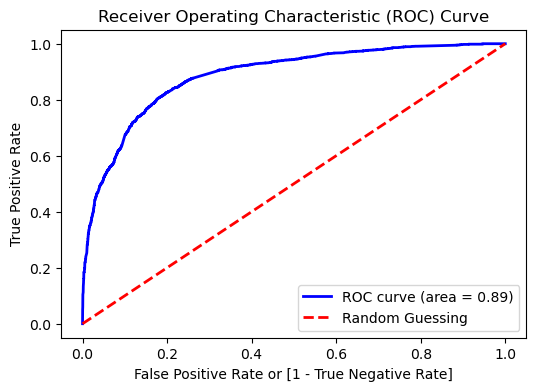

In [153]:
plot_roc_curve(y_train_pred_final.Convert,y_train_pred_final.Convert_Prob)

###### The area under ROC curve is 0.89 which indicates our model is a good one

## Step 10: Finding Optimal Cutoff

In [154]:
# Lets create a column with different cutoff values
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Convert_Prob.map(lambda x : 1 if x > i else 0)
y_train_pred_final

Convert  Convert_Prob  Prospect ID  Predicted  0.0  0.1  0.2  0.3  0.4  \
0           0      0.196697         3009          0    1    1    0    0    0   
1           0      0.125746         1012          0    1    1    0    0    0   
2           0      0.323477         9226          0    1    1    1    1    0   
3           1      0.865617         4750          1    1    1    1    1    1   
4           1      0.797752         7987          1    1    1    1    1    1   
...       ...           ...          ...        ...  ...  ...  ...  ...  ...   
6346        0      0.184223          367          0    1    1    0    0    0   
6347        1      0.935788           82          1    1    1    1    1    1   
6348        0      0.916621         8199          1    1    1    1    1    1   
6349        0      0.217132         7077          0    1    1    1    0    0   
6350        0      0.290157         5754          0    1    1    1    0    0   

      0.5  0.6  0.7  0.8  0.9  
0       0    0    0    0    0  
1       0    0    0    0    0  
2       0    0    0    0    0  
3       1    1    1    1    0  
4       1    1    1    0    0  
...   ...  ...  ...  ...  ...  
6346    0    0    0    0    0  
6347    1    1    1    1    1  
6348    1    1    1    1    1  
6349    0    0    0    0    0  
6350    0    0    0    0    0  

[6351 rows x 14 columns]

In [155]:
# Calculating accuracy, sensitivity, specificity, and precision for various probability cutoffs from 0.1 to 0.9.
df = pd.DataFrame(columns=['Probability','Accuracy','Sensitivity','Specificity','Precision'])

for i in numbers:
    Accuracy, Senstivity, Specificity, Precision = model_evaluation(y_train_pred_final.Convert, y_train_pred_final[i])
    df.loc[i] = [i, Accuracy, Senstivity, Specificity, Precision]

df

Probability  Accuracy  Sensitivity  Specificity  Precision
0.0          0.0  0.385136     1.000000     0.000000   0.385136
0.1          0.1  0.586049     0.973426     0.343406   0.481496
0.2          0.2  0.748386     0.916599     0.643022   0.616612
0.3          0.3  0.801449     0.849959     0.771063   0.699294
0.4          0.4  0.816564     0.772690     0.844046   0.756303
0.5          0.5  0.816879     0.706051     0.886300   0.795486
0.6          0.6  0.797040     0.600572     0.920102   0.824818
0.7          0.7  0.786963     0.531889     0.946735   0.862160
0.8          0.8  0.761297     0.424775     0.972087   0.905052
0.9          0.9  0.720831     0.294767     0.987708   0.937581

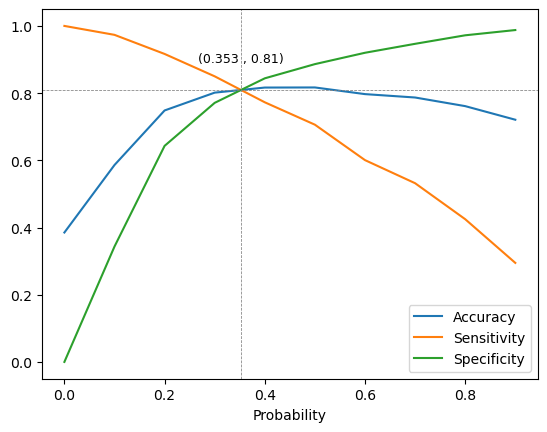

In [156]:
# Let's plot accuracy sensitivity and specificity for various probabilities.

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# Finding the intersection points of the sensitivity and accuracy curves
sensi_interp = interp1d(df['Probability'], df['Sensitivity'], kind='linear')
acc_interp = interp1d(df['Probability'], df['Accuracy'], kind='linear')
intersection_1 = np.round(float(fsolve(lambda x : sensi_interp(x) - acc_interp(x), 0.5)), 3)

# Find the intersection points of the specificity and accuracy curves
speci_interp = interp1d(df['Probability'], df['Specificity'], kind='linear')
intersection_2 = np.round(float(fsolve(lambda x : speci_interp(x) - acc_interp(x), 0.5)), 3)

# Calculate the average of the two intersection points
intersection_x = (intersection_1 + intersection_2) / 2

# Interpolate the accuracy, sensitivity, and specificity at the intersection point
accuracy_at_intersection = np.round(float(acc_interp(intersection_x)), 2)
sensitivity_at_intersection = np.round(float(sensi_interp(intersection_x)), 2)
specificity_at_intersection = np.round(float(speci_interp(intersection_x)), 2)

# Plot the three curves and add vertical and horizontal lines at intersection point
df.plot.line(x='Probability', y=['Accuracy', 'Sensitivity', 'Specificity'])
plt.axvline(x=intersection_x, color='grey',linewidth=0.55, linestyle='--')
plt.axhline(y=accuracy_at_intersection, color='grey',linewidth=0.55, linestyle='--')

# Adding annotation to display the (x,y) intersection point coordinates 
plt.annotate(f'({intersection_x} , {accuracy_at_intersection})',
             xy=(intersection_x, accuracy_at_intersection),
             xytext=(0,20),
             textcoords='offset points',
             ha='center',
             fontsize=9)

# Displaying the plot
plt.show()


- From the above graph we can take 0.354 as optimal cutoff value

In [157]:
y_train_pred_final['Final_Predictions']=y_train_pred_final.Convert_Prob.map(lambda x: 1 if x>0.35 else 0)
y_train_pred_final


Convert  Convert_Prob  Prospect ID  Predicted  0.0  0.1  0.2  0.3  0.4  \
0           0      0.196697         3009          0    1    1    0    0    0   
1           0      0.125746         1012          0    1    1    0    0    0   
2           0      0.323477         9226          0    1    1    1    1    0   
3           1      0.865617         4750          1    1    1    1    1    1   
4           1      0.797752         7987          1    1    1    1    1    1   
...       ...           ...          ...        ...  ...  ...  ...  ...  ...   
6346        0      0.184223          367          0    1    1    0    0    0   
6347        1      0.935788           82          1    1    1    1    1    1   
6348        0      0.916621         8199          1    1    1    1    1    1   
6349        0      0.217132         7077          0    1    1    1    0    0   
6350        0      0.290157         5754          0    1    1    1    0    0   

      0.5  0.6  0.7  0.8  0.9  Final_Predictions  
0       0    0    0    0    0                  0  
1       0    0    0    0    0                  0  
2       0    0    0    0    0                  0  
3       1    1    1    1    0                  1  
4       1    1    1    0    0                  1  
...   ...  ...  ...  ...  ...                ...  
6346    0    0    0    0    0                  0  
6347    1    1    1    1    1                  1  
6348    1    1    1    1    1                  1  
6349    0    0    0    0    0                  0  
6350    0    0    0    0    0                  0  

[6351 rows x 15 columns]

In [158]:
## Assigning lead scores 
y_train_pred_final['Lead_Scores']=y_train_pred_final.Convert_Prob.map(lambda x : round(x*100))
y_train_pred_final.head()


Convert  Convert_Prob  Prospect ID  Predicted  0.0  0.1  0.2  0.3  0.4  \
0        0      0.196697         3009          0    1    1    0    0    0   
1        0      0.125746         1012          0    1    1    0    0    0   
2        0      0.323477         9226          0    1    1    1    1    0   
3        1      0.865617         4750          1    1    1    1    1    1   
4        1      0.797752         7987          1    1    1    1    1    1   

   0.5  0.6  0.7  0.8  0.9  Final_Predictions  Lead_Scores  
0    0    0    0    0    0                  0           20  
1    0    0    0    0    0                  0           13  
2    0    0    0    0    0                  0           32  
3    1    1    1    1    0                  1           87  
4    1    1    1    0    0                  1           80

In [159]:
# Checking the overall Acuuracy
print('Accuracy Score',accuracy_score(y_train_pred_final.Convert,y_train_pred_final.Final_Predictions))

Accuracy Score 0.8135726657219335


In [160]:
model_evaluation(y_train_pred_final.Convert,y_train_pred_final.Final_Predictions,print_score=True)

Confusion Matrix: 
 [[3183  722]
 [ 462 1984]]
Accuracy:  0.8135726657219335
Senstivity:  0.8111201962387572
Specificity:  0.8151088348271447
Precision:  0.7331855136733185
Recall:  0.8111201962387572
True Positive Rate(TPR):  0.8111201962387572
False Positive Rate(FPR):  0.1848911651728553


(0.8135726657219335,
 0.8111201962387572,
 0.8151088348271447,
 0.7331855136733185)

### Precision and Recall

In [161]:
print('Precision Score: ',precision_score(y_train_pred_final.Convert,y_train_pred_final.Predicted))

Precision Score:  0.7954859511745739


In [162]:
print('Recall Score: ',recall_score(y_train_pred_final.Convert,y_train_pred_final.Final_Predictions))

Recall Score:  0.8111201962387572


### Precision and Recall Curve

In [163]:
from sklearn.metrics import precision_recall_curve

# Assuming y_train_pred_final has the true labels and predicted probabilities
y_true = y_train_pred_final['Convert']
y_scores = y_train_pred_final['Convert_Prob']

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

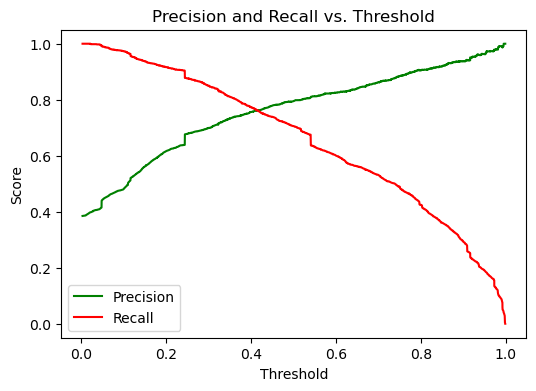

In [164]:
# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], "g-", label="Precision")
plt.plot(thresholds, recall[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.show()

- from the above graph we can say there is a trade off between Precision and Recall

## Making Predictions on Test data

In [165]:
# Scaling the features
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]=scalar.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_test.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
3271             0            0     0.284772                    -0.600595   
1490             0            0     0.643547                     1.887326   
7936             0            0    -0.432779                    -0.752879   
4216             0            0    -1.150329                    -0.888650   
3830             0            0     1.719873                    -0.587751   

      Page Views Per Visit  Lead Origin_Landing Page Submission  \
3271              0.955505                                    0   
1490              1.510766                                    1   
7936             -0.155018                                    0   
4216             -1.265540                                    0   
3830              2.066027                                    1   

      Lead Origin_Lead Add Form  Lead Origin_Lead Import  Lead Source_Google  \
3271                          0                        0                   1   
1490                          0                        0                   0   
7936                          0                        0                   1   
4216                          1                        0                   0   
3830                          0                        0                   0   

      Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
3271                       0                           0                   0   
1490                       0                           0                   0   
7936                       0                           0                   0   
4216                       0                           0                   0   
3830                       0                           1                   0   

      Lead Source_Reference  Lead Source_Referral Sites  \
3271                      0                           0   
1490                      0                           0   
7936                      0                           0   
4216                      1                           0   
3830                      0                           0   

      Lead Source_Welingak Website  Last Activity_Email Bounced  \
3271                             0                            0   
1490                             0                            0   
7936                             0                            0   
4216                             0                            0   
3830                             0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Opened  \
3271                                 0                           1   
1490                                 0                           1   
7936                                 0                           1   
4216                                 0                           1   
3830                                 0                           1   

      Last Activity_Form Submitted on Website  \
3271                                        0   
1490                                        0   
7936                                        0   
4216                                        0   
3830                                        0   

      Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
3271                                      0                               0   
1490                                      0                               0   
7936                                      0                               0   
4216                                      0                               0   
3830                                      0                               0   

      Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
3271                                      0                       0   
1490                                      0                       0   
7936            

In [166]:
# selecting the columns that are extracted from the final model
X_test=X_test[col1]
X_test.head()

Do Not Email  Total Time Spent on Website  \
3271             0                    -0.600595   
1490             0                     1.887326   
7936             0                    -0.752879   
4216             0                    -0.888650   
3830             0                    -0.587751   

      Lead Origin_Landing Page Submission  Lead Source_Olark Chat  \
3271                                    0                       0   
1490                                    1                       0   
7936                                    0                       0   
4216                                    0                       0   
3830                                    1                       0   

      Lead Source_Reference  Lead Source_Welingak Website  \
3271                      0                             0   
1490                      0                             0   
7936                      0                             0   
4216                      1                             0   
3830                      0                             0   

      Last Activity_Olark Chat Conversation  Last Activity_Other Activities  \
3271                                      0                               0   
1490                                      0                               0   
7936                                      0                               0   
4216                                      0                               0   
3830                                      0                               0   

      Last Activity_SMS Sent  Specialization_Other Specialization  \
3271                       0                                    1   
1490                       0                                    0   
7936                       0                                    1   
4216                       0                                    0   
3830                       0                                    0   

      What is your current occupation_Working Professional  \
3271                                                  0      
1490                                                  1      
7936                                                  0      
4216                                                  0      
3830                                                  0      

      Last Notable Activity_Modified  
3271                               0  
1490                               0  
7936                               0  
4216                               1  
3830                               0

In [167]:
# Adding constant
X_test_sm = sm.add_constant(X_test)

In [168]:

y_test_pred=res.predict(X_test_sm)
y_test_pred

3271    0.130342
1490    0.969057
7936    0.112570
4216    0.802999
3830    0.132924
          ...   
850     0.191657
2879    0.127680
6501    0.854745
7155    0.112011
376     0.086451
Length: 2723, dtype: float64

In [169]:
# converting to a dataframe
y_test_pred_df = pd.DataFrame(y_test_pred)
y_test_pred_df

0
3271  0.130342
1490  0.969057
7936  0.112570
4216  0.802999
3830  0.132924
...        ...
850   0.191657
2879  0.127680
6501  0.854745
7155  0.112011
376   0.086451

[2723 rows x 1 columns]

In [170]:
# converting to a dataframe
y_test_df = pd.DataFrame(y_test) 

In [171]:
y_test_df.head()

Converted
3271          0
1490          1
7936          0
4216          1
3830          0

In [172]:
# Addong id to the dataframe
y_test_df['Prospect ID']=y_test_df.index

In [173]:
y_test_df

Converted  Prospect ID
3271          0         3271
1490          1         1490
7936          0         7936
4216          1         4216
3830          0         3830
...         ...          ...
850           0          850
2879          0         2879
6501          1         6501
7155          0         7155
376           0          376

[2723 rows x 2 columns]

In [174]:
# Dropping the index in both the data frames
y_test_pred_df.reset_index(drop=True,inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [175]:
# Concatinating both the data frames
y_pred_final=pd.concat([y_test_df,y_test_pred_df],axis =1)
y_pred_final

Converted  Prospect ID         0
0             0         3271  0.130342
1             1         1490  0.969057
2             0         7936  0.112570
3             1         4216  0.802999
4             0         3830  0.132924
...         ...          ...       ...
2718          0          850  0.191657
2719          0         2879  0.127680
2720          1         6501  0.854745
2721          0         7155  0.112011
2722          0          376  0.086451

[2723 rows x 3 columns]

In [176]:
# Renaming the column to Convert_prob
y_pred_final=y_pred_final.rename(columns={0:'Convert_Prob'})
y_pred_final

Converted  Prospect ID  Convert_Prob
0             0         3271      0.130342
1             1         1490      0.969057
2             0         7936      0.112570
3             1         4216      0.802999
4             0         3830      0.132924
...         ...          ...           ...
2718          0          850      0.191657
2719          0         2879      0.127680
2720          1         6501      0.854745
2721          0         7155      0.112011
2722          0          376      0.086451

[2723 rows x 3 columns]

In [177]:
y_pred_final=y_pred_final.reindex(columns=['Prospect ID','Converted','Convert_Prob'])
y_pred_final

Prospect ID  Converted  Convert_Prob
0            3271          0      0.130342
1            1490          1      0.969057
2            7936          0      0.112570
3            4216          1      0.802999
4            3830          0      0.132924
...           ...        ...           ...
2718          850          0      0.191657
2719         2879          0      0.127680
2720         6501          1      0.854745
2721         7155          0      0.112011
2722          376          0      0.086451

[2723 rows x 3 columns]

In [178]:
y_pred_final['Final_Predicted']=y_pred_final.Convert_Prob.map(lambda x : 1 if x > 0.35 else 0)
y_pred_final

Prospect ID  Converted  Convert_Prob  Final_Predicted
0            3271          0      0.130342                0
1            1490          1      0.969057                1
2            7936          0      0.112570                0
3            4216          1      0.802999                1
4            3830          0      0.132924                0
...           ...        ...           ...              ...
2718          850          0      0.191657                0
2719         2879          0      0.127680                0
2720         6501          1      0.854745                1
2721         7155          0      0.112011                0
2722          376          0      0.086451                0

[2723 rows x 4 columns]

In [179]:
# checking the accuracy,senstivity,specificity,confusion matrix
model_evaluation(y_pred_final.Converted,y_pred_final.Final_Predicted,print_score=True)

Confusion Matrix: 
 [[1409  325]
 [ 197  792]]
Accuracy:  0.8082996694821888
Senstivity:  0.8008088978766431
Specificity:  0.8125720876585929
Precision:  0.7090420769919427
Recall:  0.8008088978766431
True Positive Rate(TPR):  0.8008088978766431
False Positive Rate(FPR):  0.18742791234140715


(0.8082996694821888,
 0.8008088978766431,
 0.8125720876585929,
 0.7090420769919427)

In [180]:
# now lets add Lead Score to the y_pred_final.
y_pred_final['Lead_Score'] = y_pred_final.Convert_Prob.map(lambda x : round(x*100))
y_pred_final

Prospect ID  Converted  Convert_Prob  Final_Predicted  Lead_Score
0            3271          0      0.130342                0          13
1            1490          1      0.969057                1          97
2            7936          0      0.112570                0          11
3            4216          1      0.802999                1          80
4            3830          0      0.132924                0          13
...           ...        ...           ...              ...         ...
2718          850          0      0.191657                0          19
2719         2879          0      0.127680                0          13
2720         6501          1      0.854745                1          85
2721         7155          0      0.112011                0          11
2722          376          0      0.086451                0           9

[2723 rows x 5 columns]

### Observations

- Accuracy:  0.8049944913698127
- Senstivity:  0.8048533872598584
- Specificity:  0.8050749711649365

### Now lets compare the results of both train and test sets
---------------------
##### Train set
- Accuracy:  0.8135726657219335
- Senstivity:  0.8111201962387572
- Specificity:  0.8151088348271447
- Precision:  0.7331855136733185

--------------------
##### Test set
- Accuracy:  0.8082996694821888
- Senstivity:  0.8008088978766431
- Specificity:  0.8125720876585929
- Precision:  0.7090420769919427

---------------------

- We have successfully achieved our goal of estimating the target lead conversion rate to be approximately 80%. The model appears to predict the conversion rate accurately, providing the CEO with confidence to make informed decisions that aim to achieve this higher lead conversion rate of 80%.

### Now lets find out which Leads should we contact

In [181]:
hot_leads = y_pred_final.loc[y_pred_final['Lead_Score']>=85]
hot_leads

Prospect ID  Converted  Convert_Prob  Final_Predicted  Lead_Score
1            1490          1      0.969057                1          97
8            4223          1      0.916621                1          92
16           1946          1      0.924467                1          92
21           2461          1      0.992551                1          99
23           5822          1      0.997991                1         100
...           ...        ...           ...              ...         ...
2694         1566          1      0.947723                1          95
2699         6461          1      0.961562                1          96
2703         5741          1      0.908283                1          91
2715         6299          1      0.871977                1          87
2720         6501          1      0.854745                1          85

[368 rows x 5 columns]

- so we can see that there are 368 hot_leads to be contacted which have high chance of conversion

In [182]:
# Now lets take a look at which Prospect_ID to be contacted
print('Prospect_ID to be contacted are')

hot_leads_ids = hot_leads['Prospect ID'].values.reshape(-1)
hot_leads_ids

Prospect_ID to be contacted are


array([1490, 4223, 1946, 2461, 5822, 2684, 2010, 4062, 7696, 9049, 1518,
       4543, 4830, 4365, 3542, 2504, 7674, 8596, 4003, 4963, 6947, 4807,
        446,  789, 8372, 5805, 3758, 1561, 5367,  737, 6423, 8286, 7174,
       4461, 1436, 7552, 3932, 4080, 1475, 5785, 2860, 7253, 4297, 5490,
       1995, 4498, 5797, 8687,  831, 7653, 2018, 6743, 3976, 5769, 1051,
       1663, 3288, 8959, 7521, 8282, 8213, 9063, 5292, 6913, 1481,  785,
       3265, 3285, 7433, 3858, 3810, 2009, 8106,  373, 7417, 4179, 8568,
       7268, 6784, 6754, 7236, 2960, 7753, 3983,  802, 8745, 4717,  505,
       8509, 6094, 4992, 7036, 2680, 7065,  112, 6149, 7157, 7175, 1675,
       6999, 5826, 8492, 6499, 2481, 3439, 4612, 7129, 4793, 4837, 2495,
        822, 8111, 2378, 5075, 7699, 5638, 2342, 8077, 2727,  720, 7489,
       2961, 1542, 5656, 2630, 6728, 8205, 6332, 8461, 2427, 5087,  174,
       2674, 8065, 2095, 1568, 8597, 4865, 3535, 4708, 1304, 6066, 6538,
       5700, 1388, 5815, 7970, 7902, 5804, 7805, 50

### Finding out what are the important Features from final model

In [183]:
res.params.sort_values(ascending=False)

Lead Source_Welingak Website                            5.811465
Lead Source_Reference                                   3.316598
What is your current occupation_Working Professional    2.608292
Last Activity_Other Activities                          2.175096
Last Activity_SMS Sent                                  1.294180
Total Time Spent on Website                             1.095412
Lead Source_Olark Chat                                  1.081908
const                                                  -0.037565
Last Notable Activity_Modified                         -0.900449
Last Activity_Olark Chat Conversation                  -0.961276
Lead Origin_Landing Page Submission                    -1.193957
Specialization_Other Specialization                    -1.202474
Do Not Email                                           -1.521825
dtype: float64

### Recommendations

- The company should prioritize calling leads from the lead sources "Welingak Websites" and "Reference" as they are more likely to convert.

- The company should prioritize calling leads who are "working professionals" as they have a higher likelihood of conversion.

- The company should prioritize calling leads who spent "more time on the websites" as they are more likely to convert.

- The company should prioritize calling leads from the lead source "Olark Chat" as they are more likely to convert.

- The company should prioritize calling leads whose last activity was "SMS Sent" as they are more likely to convert.

- The company should avoid calling leads whose last activity was "Olark Chat Conversation" as they are less likely to convert.

- The company should avoid calling leads whose lead origin is "Landing Page Submission" as they are less likely to convert.

- The company should avoid calling leads whose specialization is "Others" as they are less likely to convert.

- The company should avoid calling leads who selected "Do not Email" as "yes" as they are less likely to convert.






